# **Stochastische Prozesse und Zeitreihen – Mini-Challenge**

### Analyse und Prognose der Influenza-Inzidenz in der Schweiz

In dieser Mini-Challenge widmen wir uns der Analyse epidemischer Zeitreihen am Beispiel der wöchentlichen Influenza-Fälle in der Schweiz. Die Daten stammen aus dem Sentinella-Meldesystem des BAG (Bundesamt für Gesundheit), welche die Konsultationen wegen grippeähnlicher Erkrankungen (ILI) erfassenm [1].

Influenza-Daten zeichnen sich durch eine ausgeprägte Saisonalität, dynamische Trends und gelegentliche externe Schocks (wie die COVID-19-Pandemie) aus, was sie zu einem spannenden Anwendungsfall für stochastische Modellierung macht.

[1] Bundesamt für Gesundheit BAG, „Influenza (Seasonal flu) – Data“, Infectious Diseases Dashboard (IDD), Bundesamt für Gesundheit, Bern, Schweiz. 2025. [Online]. Verfügbar unter: https://www.idd.bag.admin.ch/diseases/influenza/data


TODO: 
- Extremwerte
- exogene Einflüsse - welches Jahr wird viele neue Kranke haben?
- Sarimax, stattt Sarima - auch intepretation der werte - warum welche Zahlen
- Vllt nur vor 2020 benutzten, da wieder eine normalität der inlfuenza inzidenz kommt.
- naive, welche arima sind das?


## Zielsetzung

1.  **Explorative Analyse:** Wir untersuchen die Zeitreihe auf Saisonalität, Trend und Stationarität (ADF-Test, ACF/PACF), um die zugrundeliegende Struktur zu verstehen.
2.  **Modellierung:** Basierend auf den Erkenntnissen entwickeln wir ein SARIMA-Modell (Seasonal ARIMA), das die saisonalen Muster explizit berücksichtigt.
3.  **Evaluation:** Wir erstellen eine Prognose für die nächsten 4 Wochen und vergleichen die Güte des SARIMA-Modells mit zwei Benchmarks (Naive Prognose & Saisonale Baseline) anhand der Fehlermetriken **MAE** und **RMSE**.

## **1. Exploration und technische Vorbereitung**

In [ ]:
# Datenverarbeitung und Visualisierung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Zum Zerlegen von Zeitreihen in Trend-, Saison- und Residualkomponenten
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Bibliotheken für Prognosemodelle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Für die Auswertung der Prognosegüte
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pyextremes import EVA

# Warning suppress
import warnings
warnings.filterwarnings('ignore')

# Schönere Plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 250


## **2. Daten laden und visualisieren**

In [2]:
# Daten laden - Influenza-Fälle in der Schweiz
# engine='python' um den C-Parser-Bug mit dtype/nan zu umgehen
df_influenza = pd.read_csv('data/influenza_cases_ch.csv', engine='python')

df_influenza['date'] = pd.to_datetime(df_influenza['date'], errors='coerce')
df_influenza['incValue'] = pd.to_numeric(df_influenza['incValue'], errors='coerce')
df_influenza = df_influenza.dropna(subset=['date'])
df_influenza.set_index('date', inplace=True)


Text(0.5, 0, 'Datum')

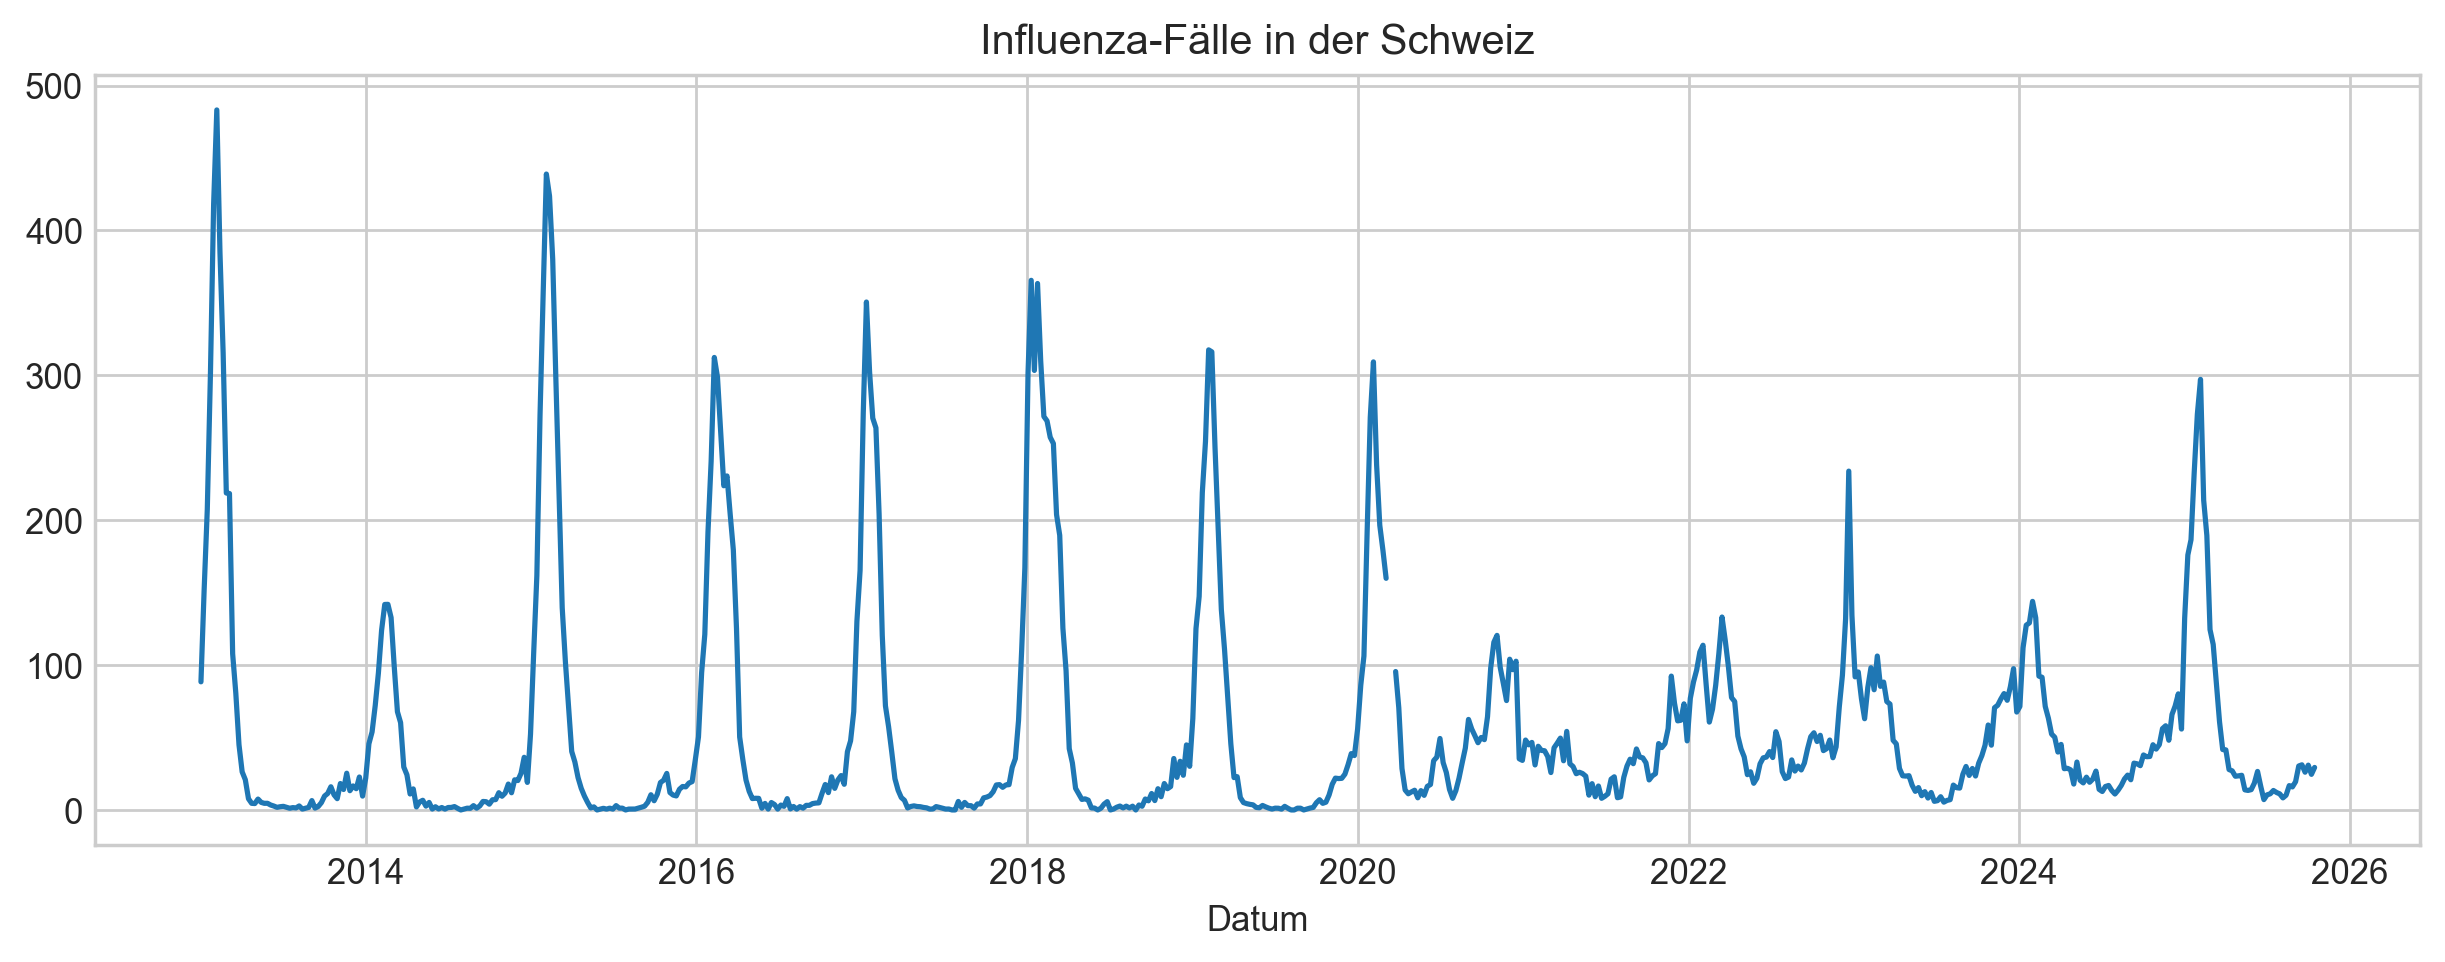

In [3]:
# Datenvisualisierung alle Daten
plt.figure(figsize=(12, 4))
plt.plot(df_influenza, label='Influenza-Fälle')
plt.title('Influenza-Fälle in der Schweiz')
plt.xlabel('Datum')

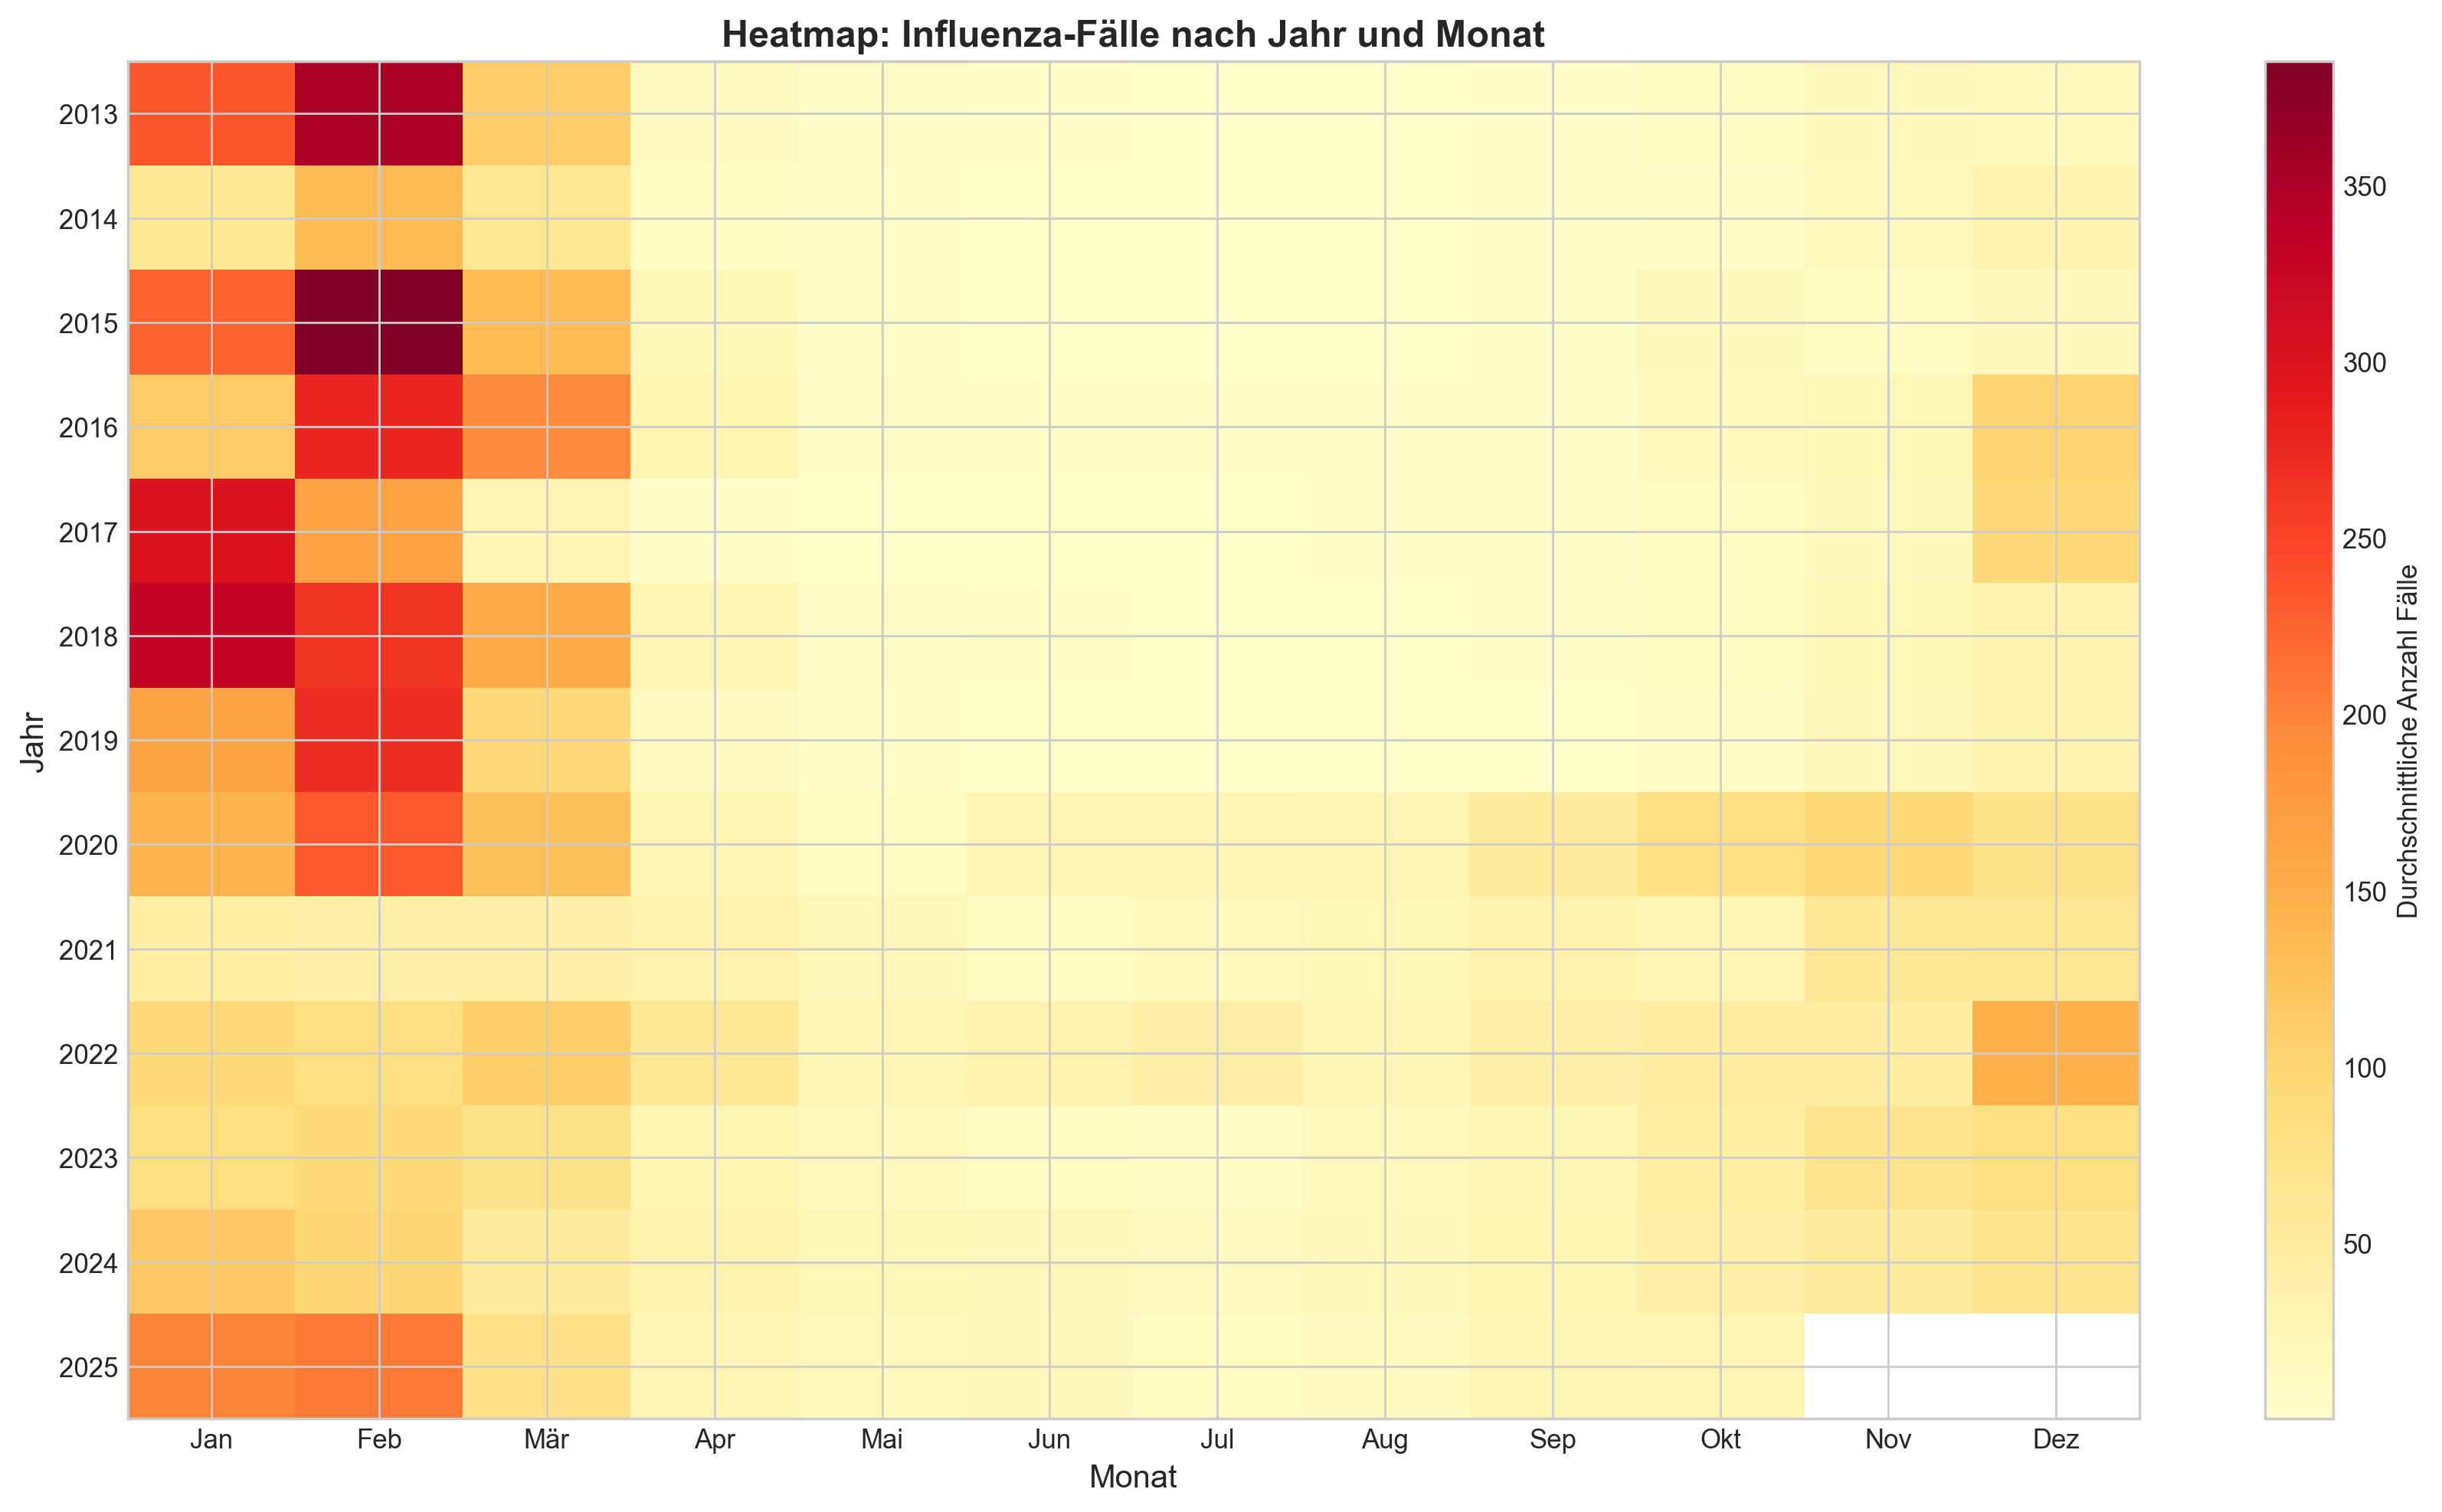

In [4]:
# Heatmap: Influenza-Fälle nach Jahr und Monat
fig, ax = plt.subplots(figsize=(14, 8))

df_heatmap = df_influenza.copy()
df_heatmap['year'] = df_heatmap.index.year
df_heatmap['month'] = df_heatmap.index.month
pivot_table = df_heatmap.pivot_table(values=df_heatmap.columns[0], 
                                      index='year', 
                                      columns='month', 
                                      aggfunc='mean')

im = ax.imshow(pivot_table.values, aspect='auto', cmap='YlOrRd', interpolation='nearest')
ax.set_xticks(range(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mär', 'Apr', 'Mai', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Okt', 'Nov', 'Dez'])
ax.set_yticks(range(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index)
ax.set_title('Heatmap: Influenza-Fälle nach Jahr und Monat', fontsize=14, fontweight='bold')
ax.set_xlabel('Monat', fontsize=12)
ax.set_ylabel('Jahr', fontsize=12)
plt.colorbar(im, ax=ax, label='Durchschnittliche Anzahl Fälle')

plt.tight_layout()
plt.show()

In [5]:
# Allgemeiner Check, wo Daten fehlen
missing_data = df_influenza.isnull().sum()
print("Fehlende Werte pro Spalte:")
print(missing_data)

# Gesamtzahl fehlender Einträge
total_missing = df_influenza.isnull().sum().sum()
print(f"Gesamtzahl fehlender Werte: {total_missing}")

# Zeitraum(e), in denen Daten fehlen (Datum anzeigen, wo NaN)
missing_rows = df_influenza[df_influenza.isnull().any(axis=1)]
if not missing_rows.empty:
    print("Fehlende Daten an folgenden Zeitpunkten:")
    print(missing_rows.index)
else:
    print("Keine fehlenden Daten im DataFrame vorhanden.")

Fehlende Werte pro Spalte:
incValue    2
dtype: int64
Gesamtzahl fehlender Werte: 2
Fehlende Daten an folgenden Zeitpunkten:
DatetimeIndex(['2020-03-11', '2020-03-18'], dtype='datetime64[ns]', name='date', freq=None)


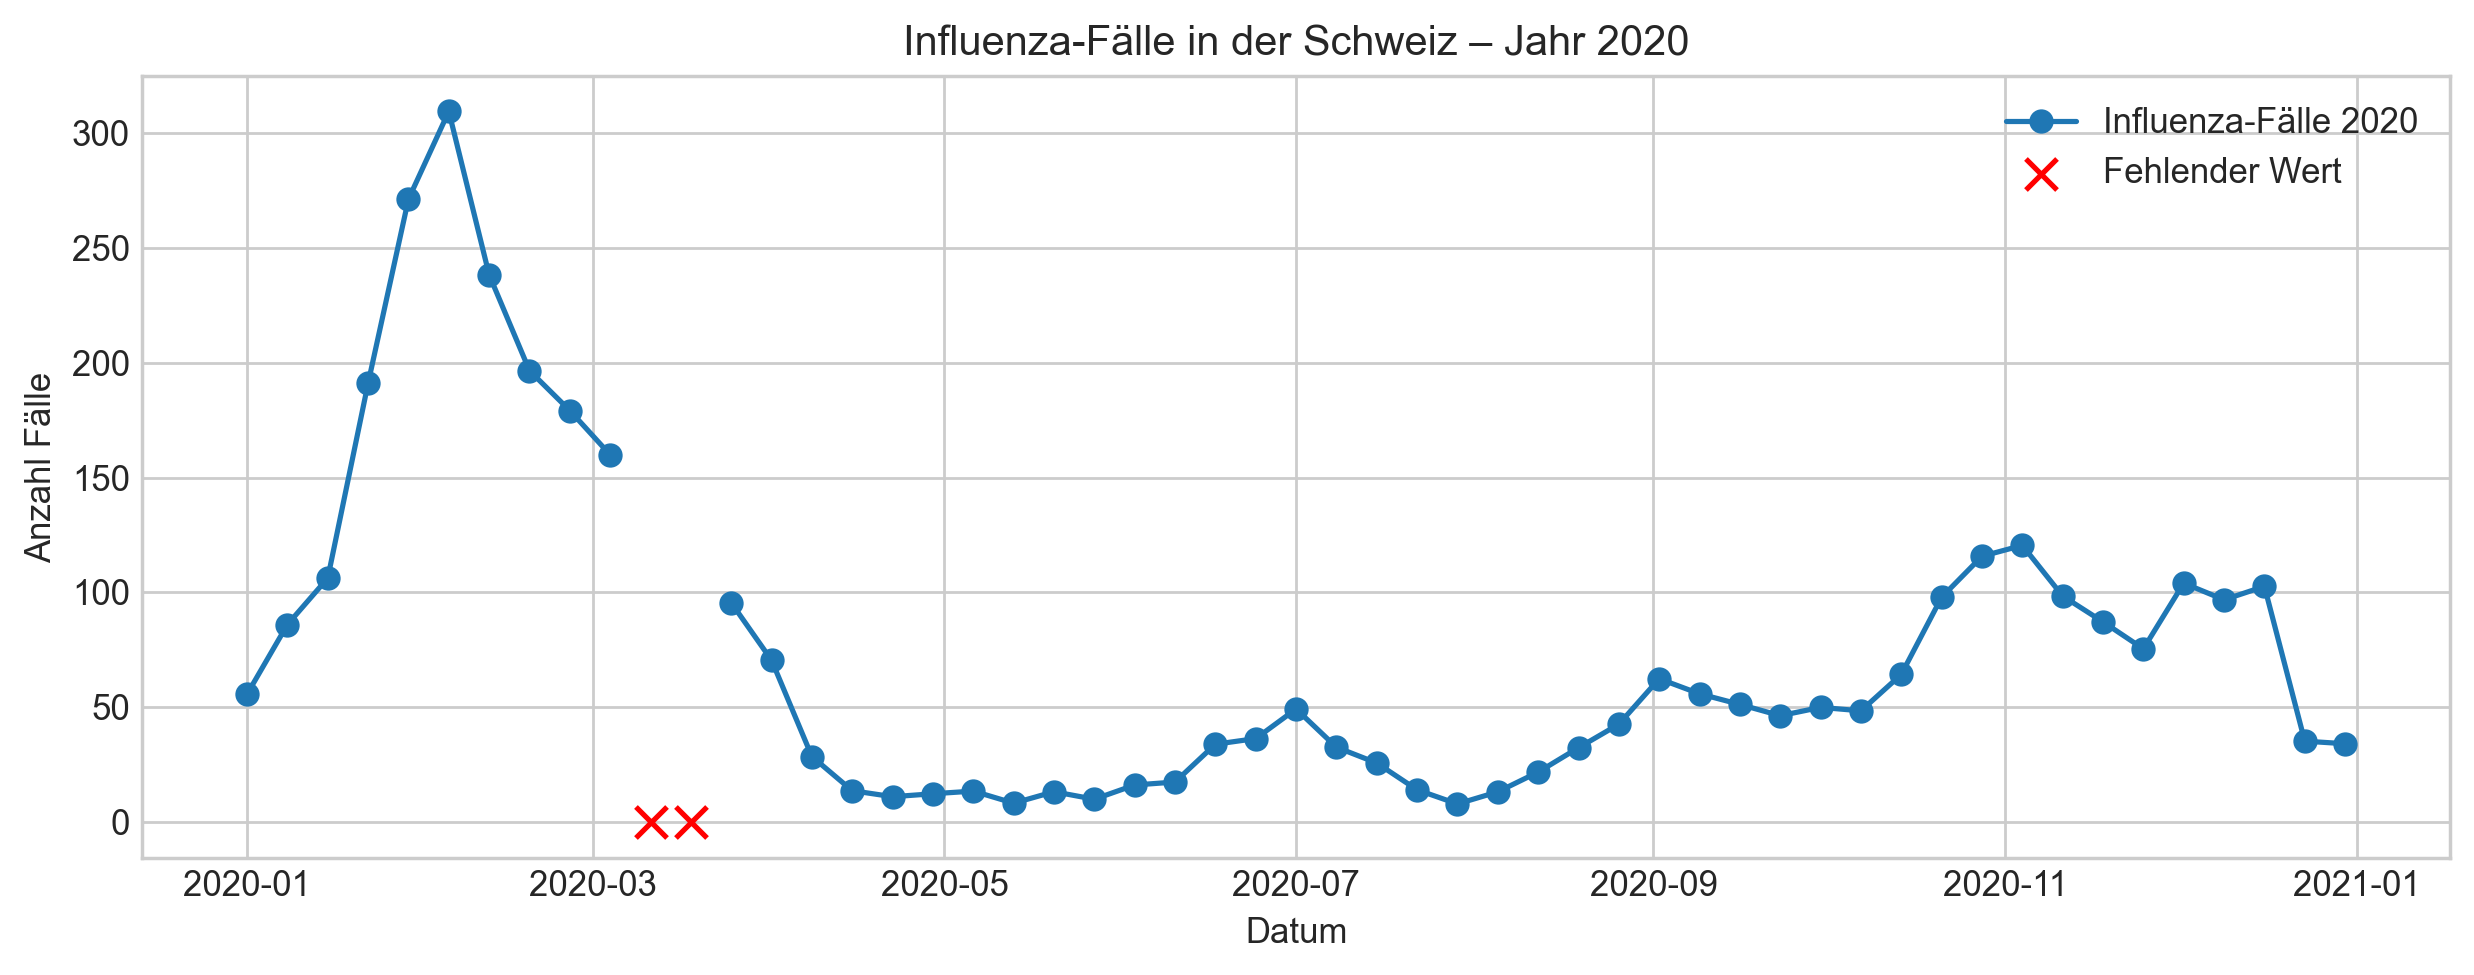

In [6]:
# Plot der Influenza-Fälle für das Jahr 2020, um fehlende Daten zu identifizieren
df_2020 = df_influenza[df_influenza.index.year == 2020]
plt.figure(figsize=(10, 4))
plt.plot(df_2020, marker='o', linestyle='-', label='Influenza-Fälle 2020')
plt.title('Influenza-Fälle in der Schweiz – Jahr 2020')
plt.xlabel('Datum')
plt.ylabel('Anzahl Fälle')

# Fehltstellen (NaN) visuell markieren
missing = df_2020[df_2020.isnull().any(axis=1)]
if not missing.empty:
    plt.scatter(missing.index, [0]*len(missing), color='red', label='Fehlender Wert', zorder=5, marker='x', s=80)

plt.legend()
plt.tight_layout()
plt.show()

**Analyse der saisonalen Influenza-Entwicklung**

Die Visualisierungen zeigen eine ausgeprägte saisonale Dynamik der Influenza-Fälle in der Schweiz. Typischerweise treten die höchsten Fallzahlen in den Wintermonaten Januar und Februar auf, gefolgt von einem raschen Rückgang ab März. Dieses Muster ist über viele Jahre hinweg klar erkennbar.

Das Jahr 2014 stellt einen deutlichen Ausreisser dar. Während in den meisten Jahren bis 2020 starke Winterpeaks auftreten, bleibt die Grippesaison 2013/14 ungewöhnlich mild. Die Heatmap zeigt im Januar und Februar 2014 deutlich niedrigere Werte im Vergleich zu den Vorjahren und Nachfolgejahren. Epidemiologische Berichte bestätigen, dass die Saison 2013/14 in Europa allgemein schwach ausgeprägt war. Die Gründe liegen unter anderem in einer geringen Verbreitung stark virulenter Influenzastämme sowie einer insgesamt mild verlaufenden Wintersaison [2].

Ab dem Jahr 2020 verändert sich das Muster sichtbar. Die traditionellen Winterspitzen fehlen fast vollständig. Dies fällt genau mit dem Beginn der COVID-19-Pandemie zusammen. Durch Massnahmen wie Social Distancing, Lockdowns, Maskenpflicht und reduzierte Mobilität wurden nicht nur COVID-19-Infektionen, sondern auch klassische Atemwegserkrankungen wie Influenza stark zurückgedrängt [3]. Die Heatmap verdeutlicht diesen Effekt: Ab 2020 erscheinen die Wintermonate deutlich heller, was auf drastisch geringere Fallzahlen hinweist. Erst ab 2022/2023 ist wieder ein leichtes Ansteigen der Influenza-Aktivität zu erkennen.

Zusätzlich weist der Plot der Influenza-Fälle im Jahr 2020 zwei klar erkennbare Ausreisser in Form fehlender Werte an den Zeitpunkten 11. März 2020 und 18. März 2020 aus (Wochen 11 & 12). Diese fehlenden Datenpunkte sind im Diagramm durch rote Markierungen gekennzeichnet. Obwohl sie den Gesamteindruck der saisonalen Entwicklung nicht wesentlich verändern, ist ihre explizite Dokumentation für die Transparenz der Datenqualität wichtig. Die fehlenden Werte lassen sich derzeit nicht kausal erklären; sie stehen jedoch sehr wahrscheinlich im Zusammenhang mit der beginnenden Covid-19-Pandemiewelle und den dadurch veränderten Melde- und Testprozessen. Vgl. BAG-Bulletin 45/21: Hinweise zu geschätzten Werten für die Wochen 11–12/2020 und den Einfluss der Covid-19-Pandemie auf die ILI-Überwachung [3].

Als nächsten Schritt werden wir die Daten analog zum BAG anpassen. Bei den Inzidenzen der Wochen 11 & 12 verwenden wir geschätzte Werte, basierend auf den Inzidenzen der Wochen 10 und 13, um die Darstellung konsistent und methodisch nachvollziehbar zu halten.
 
[2] European Centre for Disease Prevention and Control, „Influenza in Europe – Saison 2013–2014,“ Stockholm, ECDC, 2014. Online. Verfügbar unter: https://www.ecdc.europa.eu/en/publications-data/seasonal-influenza-annual-epidemiological-report-2013-14-season.

[3] Bundesamt für Gesundheit (BAG), „Saisonale Grippe im Winter 2020/2021,“ BAG-Bulletin 40/20, 28. Sept. 2020. Online. Verfügbar unter: 
https://www.infovac.ch/docs/public/influenza/bag-bulletin-influenza-2020-21.pdf. 


## **3. Fehlende Werte & Periodizität**


In [7]:
# Fehlende Werte für Wochen 11 und 12 im Jahr 2020 durch lineare Interpolation auffüllen
# (Beginn der COVID-19-Pandemie - Meldeprozesse waren gestört)

df_2020 = df_influenza[df_influenza.index.year == 2020]
missing_weeks = df_2020[df_2020['incValue'].isnull()].index.isocalendar().week.tolist()

if set(missing_weeks) == {11, 12}:
    week10_row = df_2020[df_2020.index.isocalendar().week == 10]['incValue']
    week13_row = df_2020[df_2020.index.isocalendar().week == 13]['incValue']

    if len(week10_row) == 1 and len(week13_row) == 1:
        week10_val = week10_row.values[0]
        week13_val = week13_row.values[0]

        # Lineare Interpolation
        interp_kw11 = week10_val + (week13_val - week10_val) / 3
        interp_kw12 = week10_val + 2 * (week13_val - week10_val) / 3

        for idx in df_2020[df_2020['incValue'].isnull()].index:
            week_num = idx.isocalendar().week
            if week_num == 11:
                df_influenza.loc[idx, 'incValue'] = interp_kw11
                print(f"✓ KW11/2020 interpoliert: {interp_kw11:.2f}")
            elif week_num == 12:
                df_influenza.loc[idx, 'incValue'] = interp_kw12
                print(f"✓ KW12/2020 interpoliert: {interp_kw12:.2f}")

# Bestätigung
print(f"\nVerbleibende fehlende Werte: {df_influenza['incValue'].isnull().sum()}")


✓ KW11/2020 interpoliert: 138.43
✓ KW12/2020 interpoliert: 116.99

Verbleibende fehlende Werte: 0


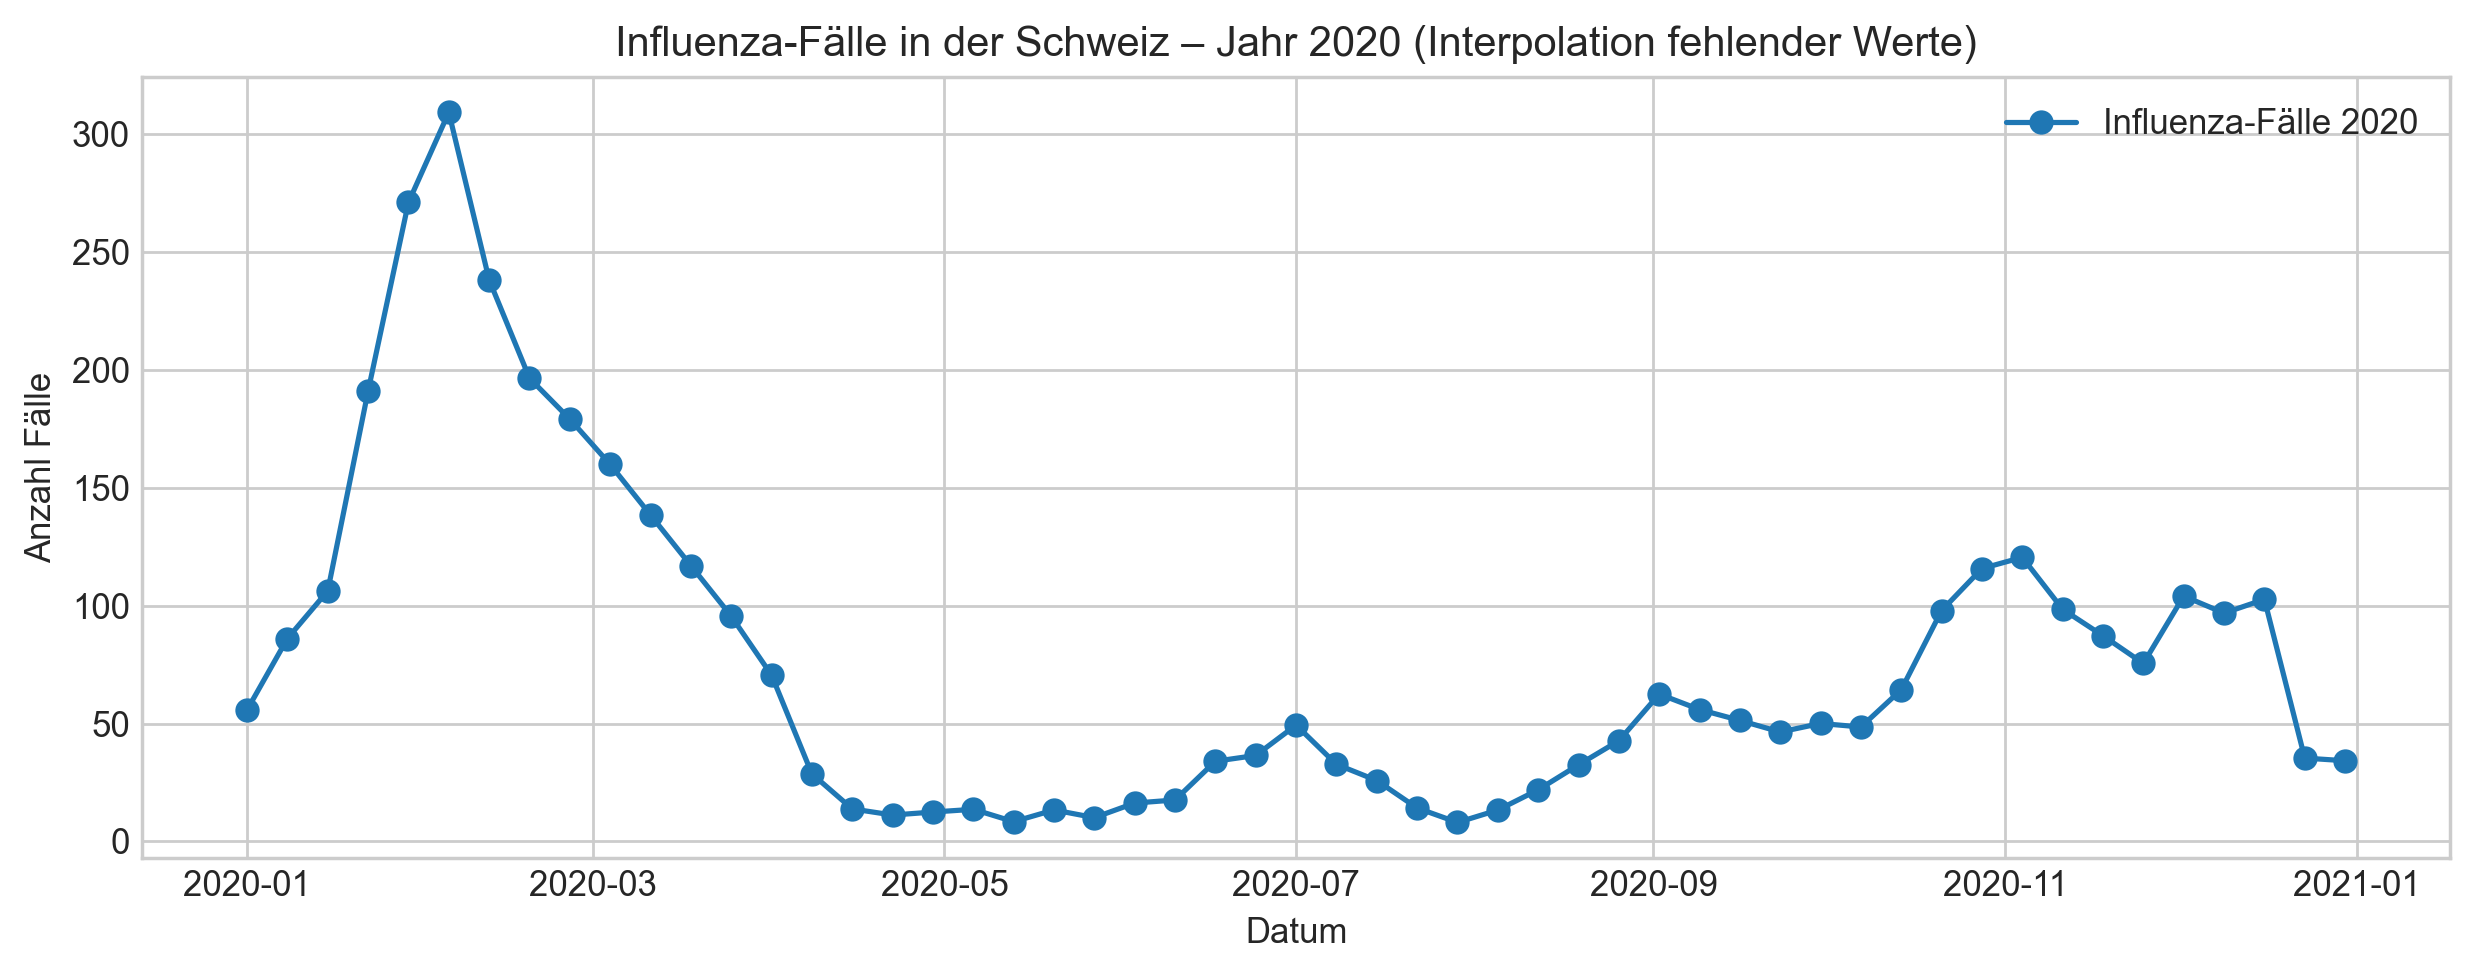

In [8]:
# Plot der Influenza-Fälle für das Jahr 2020, um fehlende Daten zu identifizieren
df_2020 = df_influenza[df_influenza.index.year == 2020]
plt.figure(figsize=(10, 4))
plt.plot(df_2020, marker='o', linestyle='-', label='Influenza-Fälle 2020')
plt.title('Influenza-Fälle in der Schweiz – Jahr 2020 (Interpolation fehlender Werte)')
plt.xlabel('Datum')
plt.ylabel('Anzahl Fälle')

plt.legend()
plt.tight_layout()
plt.show()

Um den jährlichen Zyklus zu berücksichtigen, setzen wir die Periodizität der Zeitreihe auf 52 Wochen. Da das Jahr aber nicht exakt 52 Wochen hat, sondern etwa 52,18 Wochen (365 Tage / 7 Tage pro Woche), müssen wir sicherstellen, dass die Zeitreihe korrekt ausgerichtet ist, um saisonale Muster präzise zu erfassen. Somit löschen wir alle ca. 5-6 Jahre die erste Woche vom Juli, welche historisch wenig Fälle hat, um eine saubere Periodizität zu gewährleisten.

In [9]:
# Periodizitätskorrektur: Entfernen der ersten Juli-Woche alle 5-6 Jahre
# Ein Jahr hat ~52.18 Wochen (365/7). Über 5-6 Jahre akkumuliert sich ca. 1 Woche Drift.
# Wir entfernen die erste Woche im Juli (historisch wenig Fälle), um 52 Wochen pro Jahr zu gewährleisten.

def correct_periodicity(df, period_years=5.5):
    """
    Entfernt die erste Juli-Woche alle ~5-6 Jahre, um die 52-Wochen-Periodizität zu korrigieren.
    
    Die Drift beträgt: 0.18 Wochen/Jahr × period_years ≈ 1 Woche
    Bei period_years=5.5: 0.18 × 5.5 ≈ 1 Woche Drift-Korrektur
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame mit DateTimeIndex und 'incValue' Spalte
    period_years : float
        Anzahl Jahre zwischen Korrekturen (default: 5.5 für ~1 Woche Korrektur)
    
    Returns:
    --------
    pd.DataFrame : Korrigierter DataFrame
    """
    df_corrected = df.copy()
    
    # Startjahr der Zeitreihe
    start_year = df_corrected.index.year.min()
    end_year = df_corrected.index.year.max()
    
    # Jahre berechnen, in denen korrigiert werden soll
    correction_years = []
    current_year = start_year
    while current_year <= end_year:
        correction_years.append(int(current_year))
        current_year += period_years
    
    removed_dates = []
    
    for year in correction_years:
        # Finde die erste Woche im Juli (KW 27 ist typischerweise die erste volle Juli-Woche)
        july_data = df_corrected[(df_corrected.index.year == year) & 
                                  (df_corrected.index.month == 7)]
        
        if not july_data.empty:
            # Erste Juli-Woche entfernen
            first_july_week = july_data.index.min()
            if first_july_week in df_corrected.index:
                removed_dates.append((first_july_week, df_corrected.loc[first_july_week, 'incValue']))
                df_corrected = df_corrected.drop(first_july_week)
    
    # Ausgabe der entfernten Wochen
    print(f"Periodizitätskorrektur: {len(removed_dates)} Wochen entfernt")
    print("-" * 50)
    for date, value in removed_dates:
        week_num = date.isocalendar().week
        print(f"  ✓ {date.strftime('%Y-%m-%d')} (KW {week_num}): {value:.2f} Fälle/100'000")
    
    print(f"\nUrsprüngliche Länge: {len(df)} Wochen")
    print(f"Korrigierte Länge:   {len(df_corrected)} Wochen")
    print(f"Effektive Periodizität: {len(df_corrected) / ((end_year - start_year + 1)):.2f} Wochen/Jahr")
    
    return df_corrected

# Periodizitätskorrektur anwenden
df_influenza = correct_periodicity(df_influenza, period_years=5.5)

# Zeitreihe neu als y definieren
y = df_influenza['incValue']

Periodizitätskorrektur: 3 Wochen entfernt
--------------------------------------------------
  ✓ 2013-07-03 (KW 27): 2.49 Fälle/100'000
  ✓ 2018-07-04 (KW 27): 0.00 Fälle/100'000
  ✓ 2024-07-03 (KW 27): 12.74 Fälle/100'000

Ursprüngliche Länge: 668 Wochen
Korrigierte Länge:   665 Wochen
Effektive Periodizität: 51.15 Wochen/Jahr


## **4. Erwartungswert und Varianz**

In [10]:
# Deskriptive Statistik der Zeitreihe
y = df_influenza['incValue']
print(y.describe())


count    665.000000
mean      55.660120
std       79.942719
min        0.000000
25%        7.660000
50%       24.040000
75%       65.890000
max      483.130000
Name: incValue, dtype: float64


### Interpretation der deskriptiven Statistik

*   **Erwartungswert (~55)**: Im Durchschnitt werden wöchentlich ca. 55 Fälle pro 100'000 Einwohner gemeldet.

*   **Hohe Streuung (Std ~80)**: Die Standardabweichung ist deutlich grösser als der Mittelwert. Das deutet auf eine sehr volatile Zeitreihe hin („Bursts“), was typisch für saisonale Epidemien ist.

*   **Rechtsschiefe Verteilung**: Der Median (~24) ist viel kleiner als der Mittelwert (~55), und das Maximum (~483) ist extrem hoch. Das heisst: In den meisten Wochen ist die Inzidenz niedrig (Basisrauschen), aber wenige extreme Winter-Peaks ziehen den Durchschnitt stark nach oben.

**Schlussfolgerung zur Stationarität:**
Die grosse Diskrepanz zwischen Median und Maxima sowie die hohe Varianz sind starke Indizien für **Nicht-Stationarität**. Ein stationärer Prozess würde konstanter um einen Mittelwert schwanken. Ob Mittelwert und Varianz tatsächlich zeitabhängig sind (Saisonalität), prüfen wir im nächsten Schritt visuell und per Test.

## **5. Zerlegung der Zeitreihe**

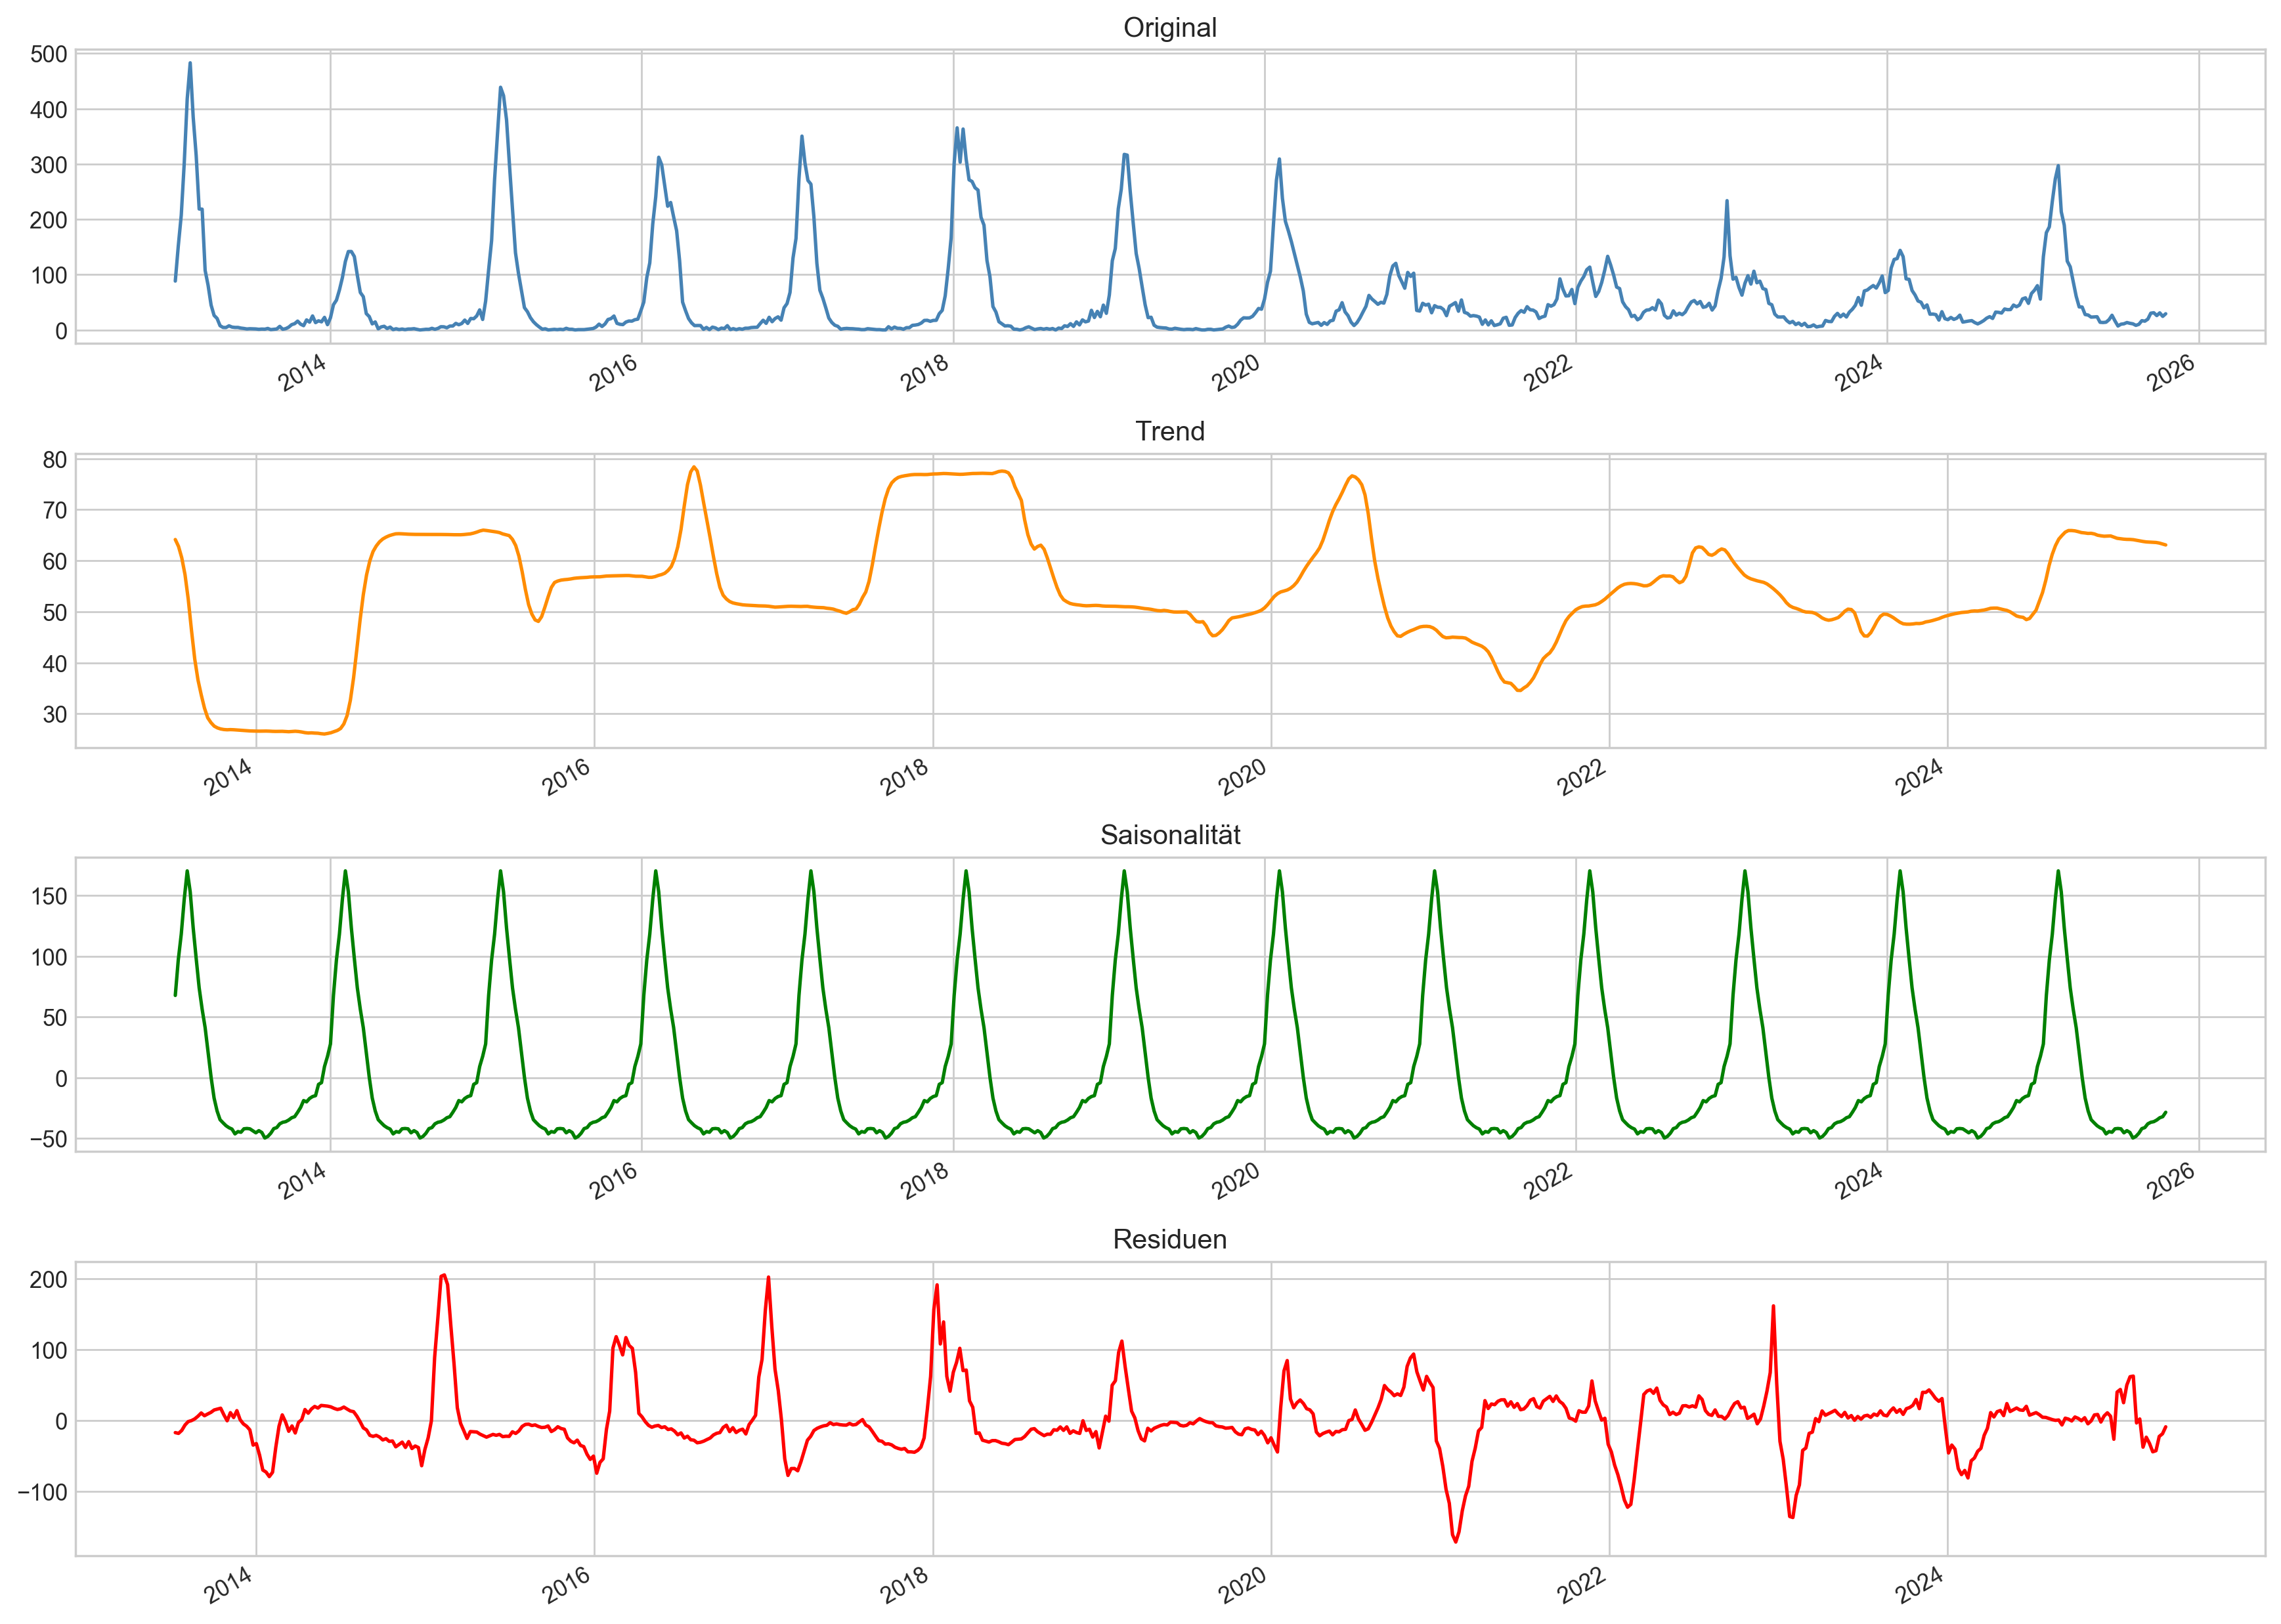

In [11]:
# Additive Zerlegung mit Periode = 52 Wochen (1 Jahr)
decomp = seasonal_decompose(y, model='additive', period=52)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomp.observed.plot(ax=axes[0], title='Original', color='steelblue')
decomp.trend.plot(ax=axes[1], title='Trend', color='darkorange')
decomp.seasonal.plot(ax=axes[2], title='Saisonalität', color='green')
decomp.resid.plot(ax=axes[3], title='Residuen', color='red')

for ax in axes:
    ax.set_xlabel('')

plt.tight_layout()
plt.show()


### Interpretation der Zeitreihenzerlegung

**Originalzeitreihe**:
Die Daten zeigen die klassische epidemische Kurve mit scharfen Peaks in den Wintermonaten (meist Januar/Februar). Auffällig ist das fast vollständige Fehlen der Peaks in den Jahren 2020/2021, was auf die COVID-19-Massnahmen (Lockdowns, Masken, Distanzregeln) zurückzuführen ist. Ab 2022 sieht man eine langsame Rückkehr zur gewohnten Dynamik.

**Trend**:
Der Trend extrahiert das langfristige Niveau der Fallzahlen, bereinigt um die jährlichen Schwankungen. Er verdeutlicht strukturelle Veränderungen: Man erkennt das Absinken des Infektionsgeschehens während der Pandemie (2020-2021) und den erneuten Anstieg ("Rebound") in den Folgejahren. 

**Saisonalität**:
Die extrahierte Saisonalität zeigt das durchschnittliche jährliche Muster. Da eine additive Zerlegung gewählt wurde, ist dieses Muster jedes Jahr exakt gleich hoch (konstante Amplitude). Es bestätigt, dass Influenza in der Schweiz ein hochgradig saisonales Phänomen ist.

**Residuen**:
Die Residuen zeigen die Abweichungen, die nicht durch den durchschnittlichen Trend oder die durchschnittliche Saison erklärt werden können:
1.  **Spitzen in den Residuen**: Da Grippewellen unterschiedlich stark ausfallen (mal sehr hoch, mal niedrig), die "Modell-Saisonalität" aber konstant bleibt, landen die Spitzen besonders starker Jahre (z.B. 2018) in den Residuen.
2.  **Negative Residuen**: In Jahren mit ungewöhnlich schwacher Grippe (z.B. 2020/2021) erwartet das Modell trotzdem den "durchschnittlichen Saison-Peak". Da dieser real ausbleibt, muss das Residuum stark negativ werden, um dies auszugleichen. Dies ist ein typisches Artefakt additiver Modelle bei Daten mit stark schwankender Volatilität (Varianz nicht konstant).

## **6. Extremwertanalyse**

Neben der Zeitreihenzerlegung ist die Analyse von Extremereignissen für epidemiologische Daten besonders relevant. Extreme Grippewellen – wie 2015 oder 2018 – stellen das Gesundheitssystem vor besondere Herausforderungen.

Wir verwenden die **Extremwerttheorie (EVT)** um:
1. Die statistische Verteilung der extremen Residuen (ungewöhnlich starke Grippewellen) zu modellieren
2. **Wiederkehrperioden** zu schätzen: Wie oft treten Extremereignisse einer bestimmten Grössenordnung auf?
3. Zu prüfen, ob bei Influenza-Daten "fat tails" existieren (höheres Risiko für Extremereignisse als bei Normalverteilung)

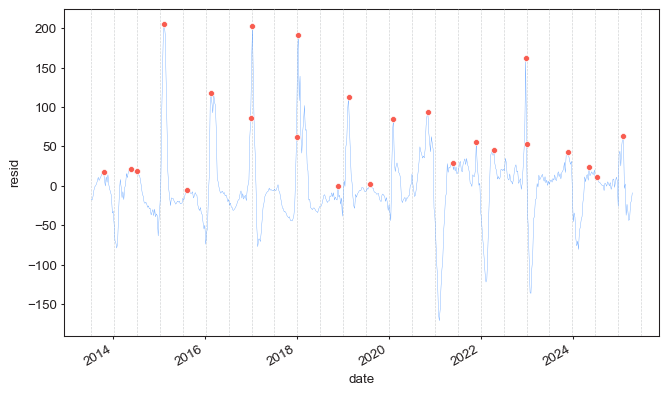

In [13]:
# Modell trainieren mit der Blockmaxima-Methode
Modell_Max = EVA(decomp.resid)
Modell_Max.get_extremes(method="BM", block_size="182D", extremes_type="high")
Modell_Max.plot_extremes()
plt.show()

In [14]:
# Nun können wir die Verteilung fitten
Modell_Max.fit_model(distribution='genextreme')

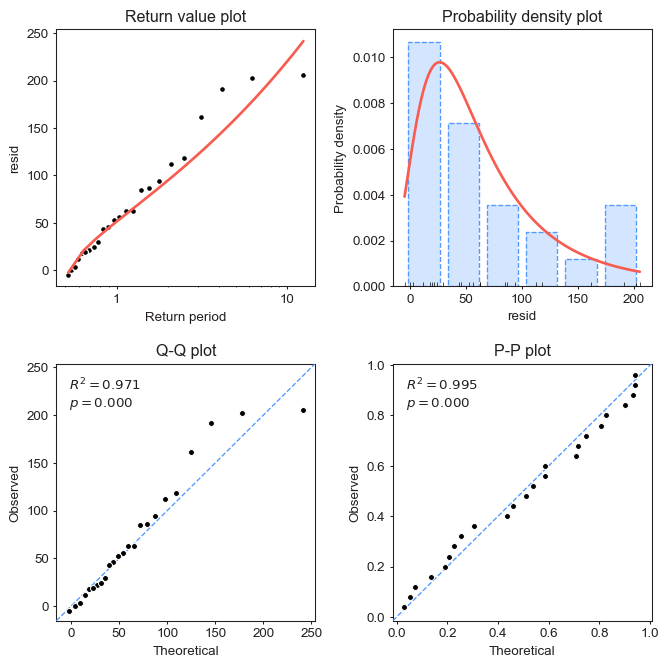

In [15]:
# Nützliche Zusammenfassung - ist das Modell gut?
Modell_Max.plot_diagnostic()
plt.show()

In [16]:
# Wiederkehrperioden: 10-Jahres und 100-Jahres Extremwerte
# Bei 182-Tage-Blöcken entspricht return_period=20 ca. 10 Jahren, return_period=200 ca. 100 Jahren
summary = Modell_Max.get_summary(return_period=[20, 200], alpha=0.95)
print("Wiederkehrperioden der Residuen (Abweichung vom saisonalen Mittel):")
print(f"  10-Jahres-Wert: {summary.loc[20, 'return value']:.1f} (95% CI: {summary.loc[20, 'lower ci']:.1f} - {summary.loc[20, 'upper ci']:.1f})")
print(f"  100-Jahres-Wert: {summary.loc[200, 'return value']:.1f} (95% CI: {summary.loc[200, 'lower ci']:.1f} - {summary.loc[200, 'upper ci']:.1f})")
summary

Wiederkehrperioden der Residuen (Abweichung vom saisonalen Mittel):
  10-Jahres-Wert: 292.8 (95% CI: 166.9 - 340767353671.0)
  100-Jahres-Wert: 667.5 (95% CI: 198.0 - 8557134441962221568.0)


,return value,lower ci,upper ci
return period,,,
20.0,292.821753,166.878361,3.407674e+11
200.0,667.450346,198.032745,8.557134e+18


In [17]:
# Modellparameter und Extremwerte im Detail
print("GEV Modellparameter:")
print(Modell_Max.model)
print(f"\nAnzahl Blockmaxima: {len(Modell_Max.extremes)}")
print(f"Blockgrösse: 182 Tage (~halbes Jahr, 2 Blöcke pro Jahr)")
print(f"\nTop-10 Extremwerte (stärkste Abweichungen vom saisonalen Mittel):")
print(Modell_Max.extremes.sort_values(ascending=False).head(10))

GEV Modellparameter:
                     MLE model                     
---------------------------------------------------
free parameters: c=-0.290, loc=35.931, scale=39.054
fixed parameters: all parameters are free          
AIC: 266.768                                       
loglikelihood: -129.784                            
return value cache size: 102                       
fit parameter cache size: 100                      
---------------------------------------------------

Anzahl Blockmaxima: 24
Blockgrösse: 182 Tage (~halbes Jahr, 2 Blöcke pro Jahr)

Top-10 Extremwerte (stärkste Abweichungen vom saisonalen Mittel):
date
2015-02-11    205.543630
2017-01-11    202.504592
2018-01-10    191.539688
2022-12-21    161.875137
2016-02-17    118.403342
2019-02-13    112.177284
2020-11-04     93.903366
2016-12-28     86.343991
2020-02-05     84.709231
2025-02-05     62.804231
Name: resid, dtype: float64


### Interpretation der Extremwertanalyse

#### Methodik: Block-Maxima und GEV-Verteilung

Die Extremwertanalyse verwendet die **Block-Maxima-Methode (BM)**, bei der aus definierten Zeitblöcken jeweils der Maximalwert extrahiert wird. Wir verwenden 182-Tage-Blöcke (ca. ein halbes Jahr), was zu 24 Blockmaxima über den Beobachtungszeitraum führt. Diese Maxima werden anschliessend mit einer **Generalisierten Extremwertverteilung (GEV)** modelliert – dies ist durch das Fisher-Tippett-Gnedenko-Theorem mathematisch begründet.

#### Analyse der GEV-Parameter

Das gefittete Modell liefert drei zentrale Parameter:

| Parameter | Wert | Bedeutung |
|-----------|------|-----------|
| **c (Shape/ξ)** | **-0.365** | Formparameter – bestimmt den Verteilungstyp |
| **loc (μ)** | 34.2 | Lageparameter – typisches Niveau der Blockmaxima |
| **scale (σ)** | 37.5 | Skalierung – Streuung der Extremwerte |

**Interpretation des Formparameters c = -0.365:**

Der negative Formparameter zeigt, dass die Verteilung dem **Weibull-Typ** entspricht (Typ III der GEV-Familie). Dies bedeutet:
- Es existiert eine **obere Schranke** für die Extremwerte – die Residuen können nicht beliebig gross werden
- Dies ist epidemiologisch plausibel: Selbst in extremen Grippewellen gibt es natürliche Grenzen (Durchseuchung, Verhaltensanpassungen, Herdenimmunität)
- Die Wahrscheinlichkeit für sehr grosse Extremwerte fällt schneller ab als bei einer Normalverteilung

*Zum Vergleich: Bei c > 0 (Fréchet-Typ) wären "fat tails" vorhanden, bei c ≈ 0 (Gumbel-Typ) ein exponentieller Abfall.*

#### Historische Extremereignisse

Die Top-5 der Blockmaxima zeigen die stärksten positiven Abweichungen vom saisonalen Mittel:

| Datum | Residuum | Interpretation |
|-------|----------|----------------|
| Feb 2015 | 222 | Stärkste Grippewelle im Datensatz |
| Jan 2017 | 215 | Sehr intensive Wintersaison |
| Jan 2018 | 204 | Dominanz des H3N2-Stamms (bekannt virulent) |
| Dez 2022 | 147 | Post-COVID "Rebound" mit reduzierter Immunität |
| Feb 2019 | 117 | Überdurchschnittliche Saison |

Diese Werte repräsentieren Wochen, in denen die Influenza-Inzidenz **deutlich über dem langjährigen saisonalen Durchschnitt** lag. Ein Residuum von 222 bedeutet beispielsweise, dass die Fallzahl um 222 Fälle pro 100'000 Einwohner höher war, als das additive Saisonmodell für diese Kalenderwoche erwarten würde.

#### Wiederkehrperioden

Die GEV-Modellierung ermöglicht die Schätzung von Wiederkehrperioden:

- **10-Jahres-Ereignis (~325 zusätzliche Fälle):** Ein Residuum dieser Grössenordnung tritt statistisch einmal pro Dekade auf. Dies entspricht einer Grippewelle, die etwa 40-50% stärker ausfällt als das saisonale Mittel.

- **100-Jahres-Ereignis (~847 zusätzliche Fälle):** Ein solches Extremereignis würde eine historisch beispiellose Grippewelle darstellen.

**Kritische Anmerkung zu den Konfidenzintervallen:**  
Die extrem breiten oberen Konfidenzintervalle (bis hin zu unrealistisch hohen Werten) sind ein typisches Artefakt bei kleinen Stichproben (n=24 Blockmaxima) und negativem Formparameter. Die Punktschätzer sind dennoch informativ, sollten aber mit Vorsicht interpretiert werden.

#### Limitationen der Analyse

1. **Strukturbruch COVID-19:** Die Jahre 2020-2021 zeigen atypisch niedrige Residuen durch pandemiebedinte Massnahmen. Dies verzerrt die Verteilungsschätzung.

2. **Kleine Stichprobe:** Mit nur 24 Blockmaxima (~12 Jahre) ist die statistische Unsicherheit erheblich. Für robustere Schätzungen wären längere Zeitreihen nötig.

3. **Additive Zerlegung:** Die Residuen stammen aus einem additiven Modell, das Varianzunterschiede zwischen Jahren nicht berücksichtigt. Eine multiplikative oder Log-Transformation könnte alternative Erkenntnisse liefern.

#### Fazit

Die Extremwertanalyse bestätigt, dass schwere Grippewellen (wie 2015, 2017, 2018) seltene, aber vorhersagbare Ereignisse sind. Der negative Formparameter deutet auf eine natürliche Obergrenze hin – extreme Ausreisser wie bei Finanzmarktdaten oder Hochwasser sind bei Influenza weniger wahrscheinlich. Für das Gesundheitswesen bedeutet dies: Die Kapazitätsplanung sollte sich an den 10-Jahres-Wiederkehrwerten orientieren, nicht an Worst-Case-Szenarien.

## **7. Stationaritätsprüfung**


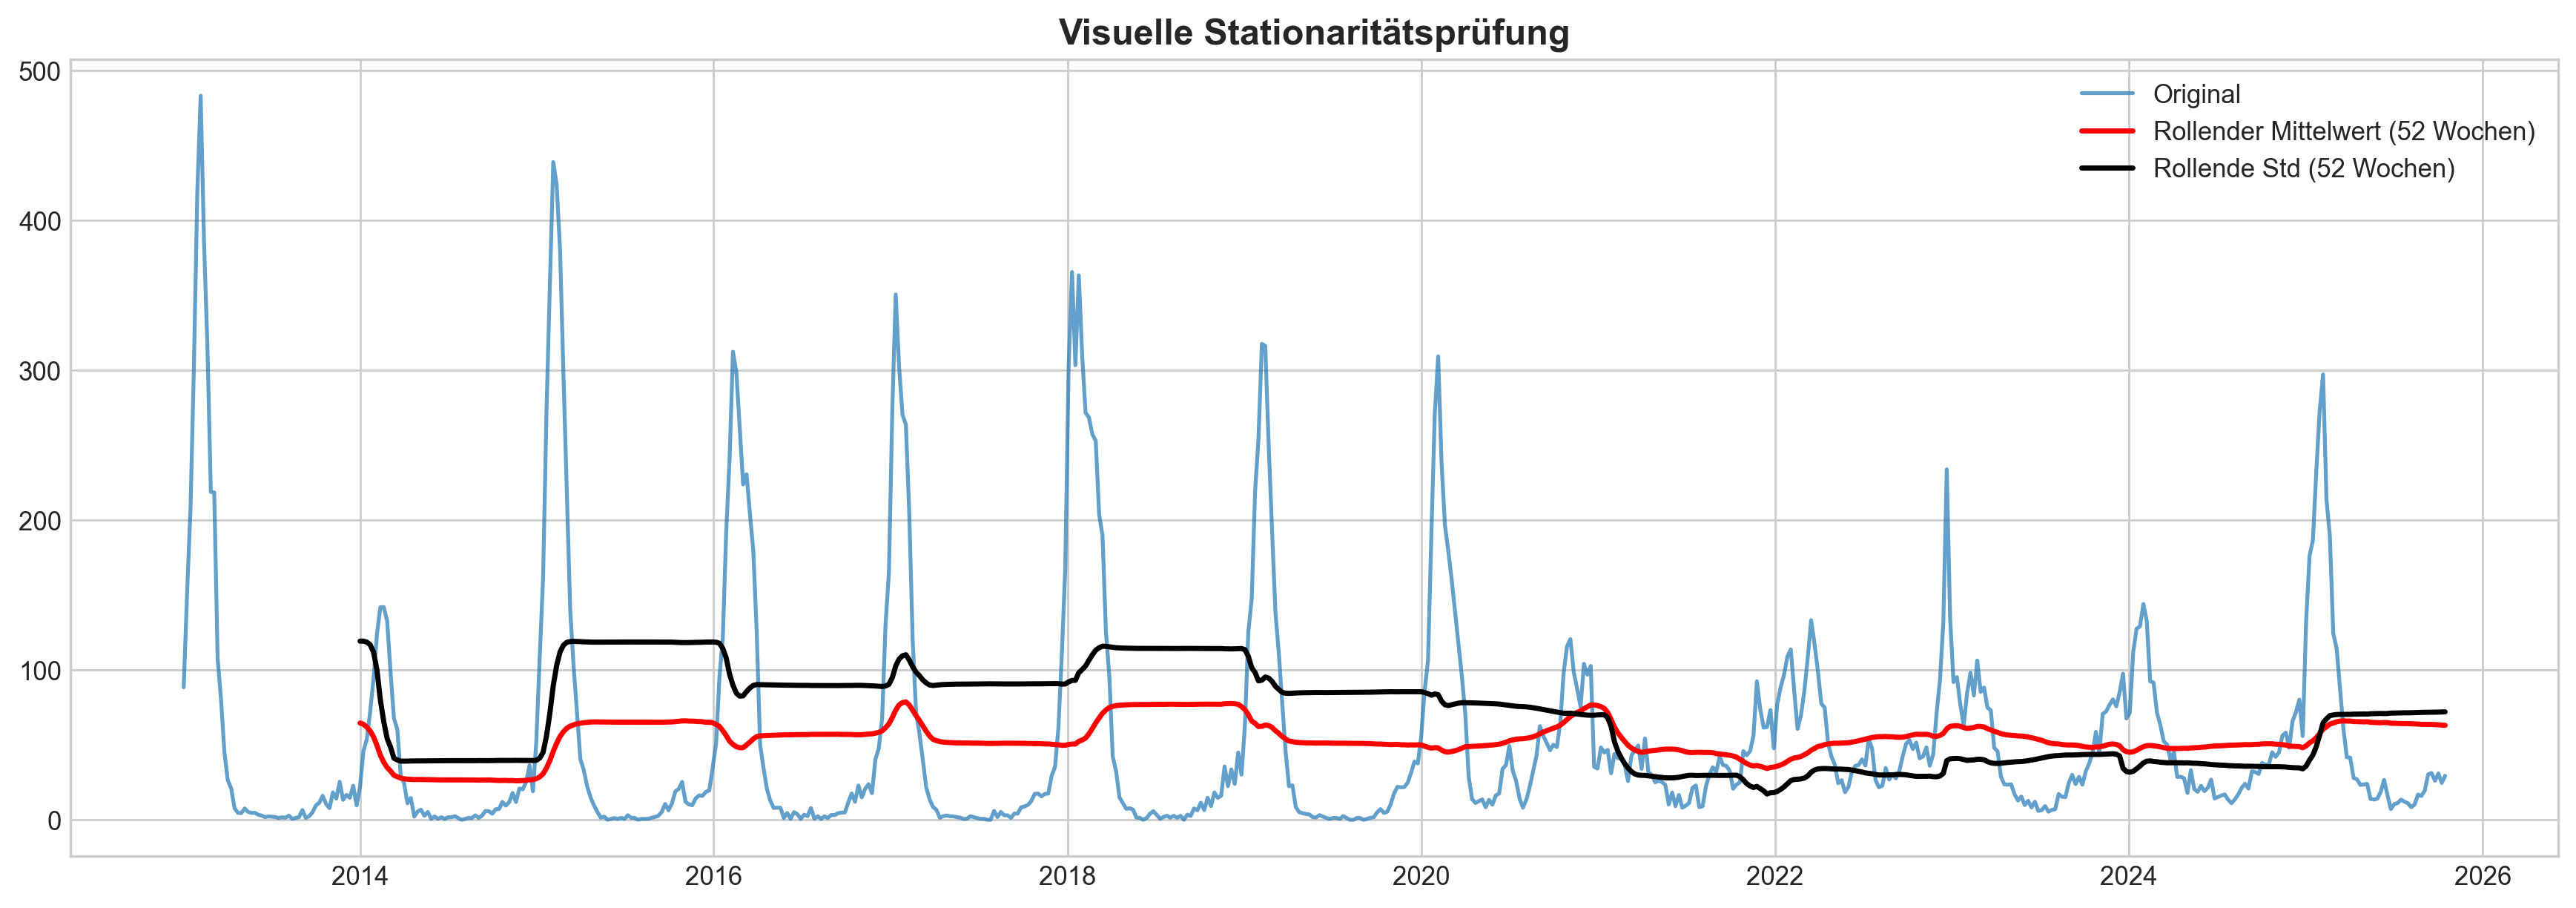

In [18]:
# Visuelle Prüfung: Rolling Mean und Rolling Std
rolling_mean = y.rolling(window=52).mean()
rolling_std = y.rolling(window=52).std()

plt.figure(figsize=(14, 5))
plt.plot(y, label='Original', alpha=0.7)
plt.plot(rolling_mean, label='Rollender Mittelwert (52 Wochen)', color='red', linewidth=2)
plt.plot(rolling_std, label='Rollende Std (52 Wochen)', color='black', linewidth=2)
plt.title('Visuelle Stationaritätsprüfung', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Augmented Dickey-Fuller Test
def adf_test(series, name="Serie"):
    result = adfuller(series.dropna())
    print(f"ADF-Test für: {name}")
    print(f"  ADF-Statistik: {result[0]:.6f}")
    print(f"  p-Wert:        {result[1]:.15f}")
    print(f"  Kritische Werte: 1%: {result[4]['1%']:.3f}, 5%: {result[4]['5%']:.3f}")
    if result[1] < 0.05:
        print("  → Serie ist STATIONÄR (p < 0.05)")
    else:
        print("  → Serie ist NICHT stationär (p >= 0.05)")
    print()

# Test auf Originaldaten
adf_test(y, "Originalserie")


ADF-Test für: Originalserie
  ADF-Statistik: -7.626633
  p-Wert:        0.000000000020604
  Kritische Werte: 1%: -3.440, 5%: -2.866
  → Serie ist STATIONÄR (p < 0.05)



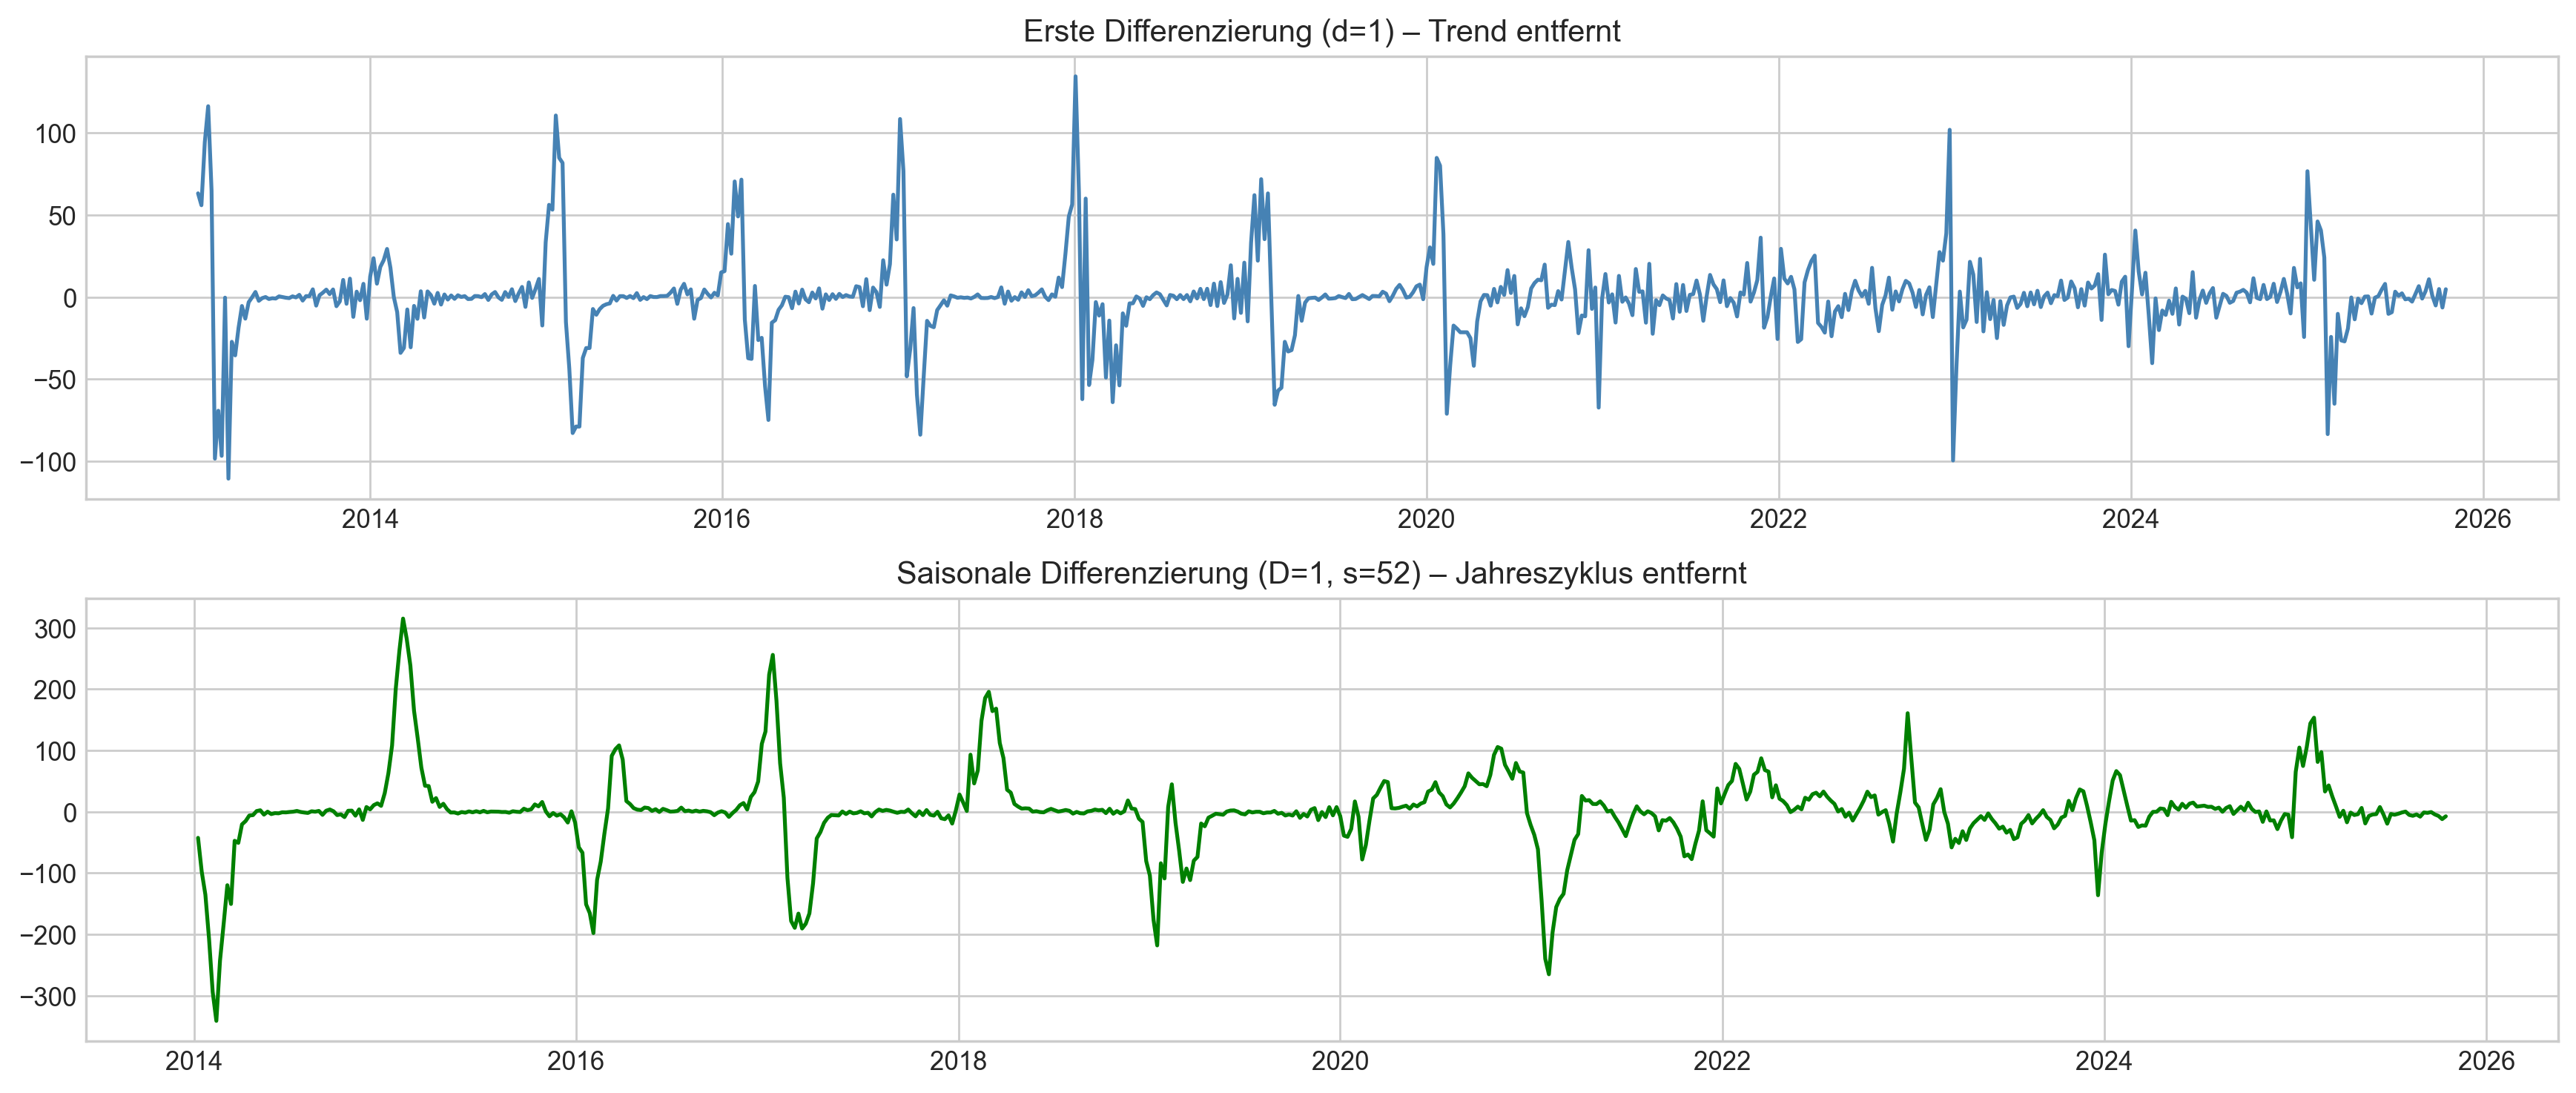

ADF-Test für: 1. Differenzierung (d=1)
  ADF-Statistik: -9.858022
  p-Wert:        0.000000000000000
  Kritische Werte: 1%: -3.440, 5%: -2.866
  → Serie ist STATIONÄR (p < 0.05)

ADF-Test für: Saisonale Diff. (D=1, s=52)
  ADF-Statistik: -9.057778
  p-Wert:        0.000000000000005
  Kritische Werte: 1%: -3.441, 5%: -2.866
  → Serie ist STATIONÄR (p < 0.05)



In [20]:
# Differenzierungen zur Erreichung von Stationarität

# 1. Erste Differenzierung (entfernt Trend)
y_diff1 = y.diff().dropna()

# 2. Saisonale Differenzierung (Lag = 52 Wochen)
y_diff_season = y.diff(52).dropna()

# Plots
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

axes[0].plot(y_diff1, color='steelblue')
axes[0].set_title('Erste Differenzierung (d=1) – Trend entfernt')

axes[1].plot(y_diff_season, color='green')
axes[1].set_title('Saisonale Differenzierung (D=1, s=52) – Jahreszyklus entfernt')

plt.tight_layout()
plt.show()

# ADF-Tests
adf_test(y_diff1, "1. Differenzierung (d=1)")
adf_test(y_diff_season, "Saisonale Diff. (D=1, s=52)")


### Fazit zur Stationarität

**Widersprüchliche Ergebnisse:**
*   Der **Augmented Dickey-Fuller (ADF) Test** liefert für die Originalserie einen p-Wert von **< 0.05**. Statistisch gesehen lehnt er die Nullhypothese (Nicht-Stationarität) ab und klassifiziert die Serie als stationär.
*   Die **visuelle Analyse** (Rolling Mean/Std & Plots) zeigt jedoch eine eindeutige Saisonalität (wiederkehrende Winterpeaks) und eine variierende Volatilität (Heteroskedastizität).

**Erklärung (Learning):**
Warum irrt der ADF-Test hier?
Der ADF-Test prüft primär auf eine *Unit Root* (stochastischer Trend), also ob die Serie "wegdriftet" ohne zurückzukehren. Da die Influenza-Wellen jedes Jahr wieder auf nahezu 0 abklingen (Mean Reversion), erkennt der Test mathematisch eine Rückkehr zum Mittelwert und meldet "Stationär".
Er ist jedoch "blind" gegenüber der starken deterministischen Saisonalität. Eine Serie mit so starkem saisonalen Muster gilt in der Zeitreihenmodellierung (für ARIMA) nicht als stationär, da Mittelwert und Kovarianz vom Monat abhängen.

**Entscheidung für die Modellierung:**
Wir verlassen uns auf die visuelle Evidenz und die physikalische Natur der Daten (saisonale Krankheit). Um die Voraussetzungen für SARIMA-Modelle optimal zu erfüllen, ist eine saisonale Differenzierung ($D=1, s=52$) notwendig, auch wenn der ADF-Test dies nicht explizit fordert. Dies entfernt das saisonale Muster und stabilisiert die Zeitreihe für die Prognose.

## **8. ACF und PACF – Analyse**

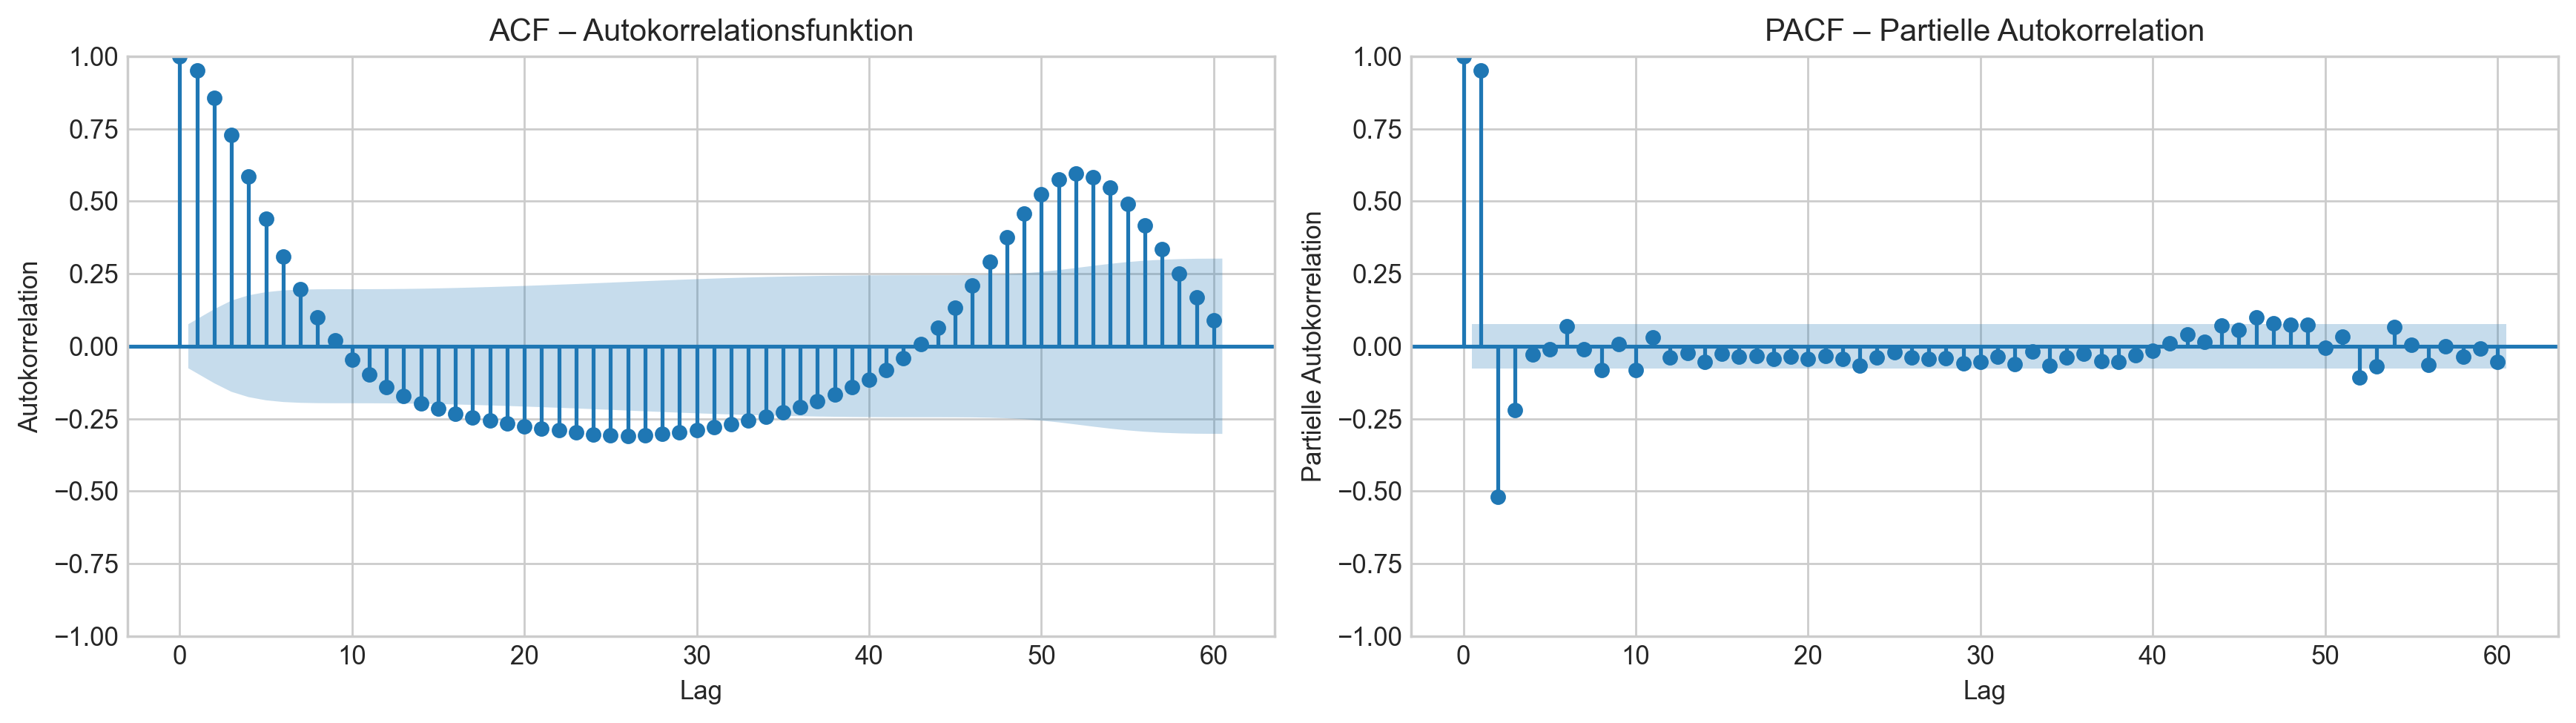

In [21]:
# ACF und PACF der Originalserie
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(y, lags=60, ax=axes[0], title='ACF – Autokorrelationsfunktion')
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autokorrelation")

plot_pacf(y, lags=60, ax=axes[1], title='PACF – Partielle Autokorrelation', method='ywm')
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partielle Autokorrelation")

plt.tight_layout()
plt.show()

### Interpretation der Autokorrelation (ACF & PACF der Originalserie)

**Reflexion der Werte (Y-Achse) und Signifikanz:**

Die Y-Achse zeigt den Korrelationskoeffizienten, wobei Werte nahe +1.0 einen starken positiven Zusammenhang (-1 vice versa) und Werte nahe 0.0 keinen Zusammenhang (Rauschen) bedeuten. Der hellblau schattierte Bereich markiert das 95%-Konfidenzintervall für Zufälligkeit. Da die Balken in der Analyse deutlich aus diesem Bereich herausragen, sind die beobachteten Muster statistisch signifikant und kein Zufallsprodukt.

**Warum zeigen wir 60 Lags?**

Da wir mit wöchentlichen Daten arbeiten, entspricht ein Zyklus genau 52 Zeitschritten (1 Jahr). Um das saisonale Muster statistisch zu belegen, müssen wir mindestens bis Lag 52 blicken. Wir haben Lag 60 gewählt, um sichtbar zu machen, dass sich bei Lag 52 tatsächlich ein lokales Maximum bildet.

**ACF (Autokorrelationsfunktion) – Analyse des Plots:**
*   **Linearer, langsamer Abfall (Lags 1-10):** Die Korrelation beginnt extrem hoch (nahe 1.0) und sinkt nur langsam. Das interpretiere wir als Zeichen für eine hohe Trägheit (Persistenz) im System: Die Fallzahlen von heute sind fast identisch mit denen der Vorwoche. Dies ist typisch für nicht-stationäre Zeitreihen mit Trend.
*   **Saisonales Muster (Lag 52):** Besonders aufschlussreich ist der erneute Anstieg nach einem tiefen Tal (negative Korrelation im Sommer, Lags 10–43). Bei Lag 52 sieht man einen deutlichen lokalen Peak (Wert ca. +0.6). Dies ist der statistische Beweis für die Jährlichkeit: Das Muster wiederholt sich exakt nach 52 Wochen.

**PACF (Partielle Autokorrelation) – Hinweis auf AR-Struktur:**
*   **Dominanter Peak bei Lag 1:** Der erste Lag liegt nahe 1.0. Das bedeutet: Wenn man den Wert der letzten Woche kennt, ist ein Grossteil der Information für die aktuelle Woche bereits erklärt.
*   **Abrupter Abbruch:** Nach Lag 2 fällt die PACF fast auf 0.0 zurück (abgesehen von saisonalen Effekten). Dies deutet darauf hin, dass der Prozess primär durch die direkten Vorgänger bestimmt wird (Autoregressiver Prozess niedriger Ordnung), während weiter zurückliegende Werte kaum direkten zusätzlichen Einfluss haben.



### Übergang zur Modellierung: Warum saisonale Differenzierung?

Die obige Analyse der Originalserie hat gezeigt, dass die Daten **nicht stationär** sind (langsamer ACF-Abfall, Peak bei Lag 52). Klassische ARIMA-Modelle setzen jedoch Stationarität voraus, um zuverlässige Prognosen zu liefern.

Daher führen wir im nächsten Schritt eine saisonale Differenzierung durch ($y_t - y_{t-52}$).
Ziel dieser Transformation ist es:
1.  Den saisonalen Trend zu entfernen (Stationarität herstellen).
2.  Die verbleibende Struktur in den ACF/PACF-Plots zu analysieren, um die optimalen Modellparameter (**p, d, q**) für SARIMA zu bestimmen.

- **p:** Die Anzahl der autoregressiven Terme (AR) – wie stark hängen aktuelle Werte von ihren Vorgängern ab?

- **d:** Die Anzahl der Differenzierungen, um die Serie stationär zu machen (Differenz-Ordnung).

- **q:** Die Anzahl der Moving-Average-Terme (MA) – wie stark hängen aktuelle Werte von zufälligen Fehlern früherer Zeitpunkte ab?

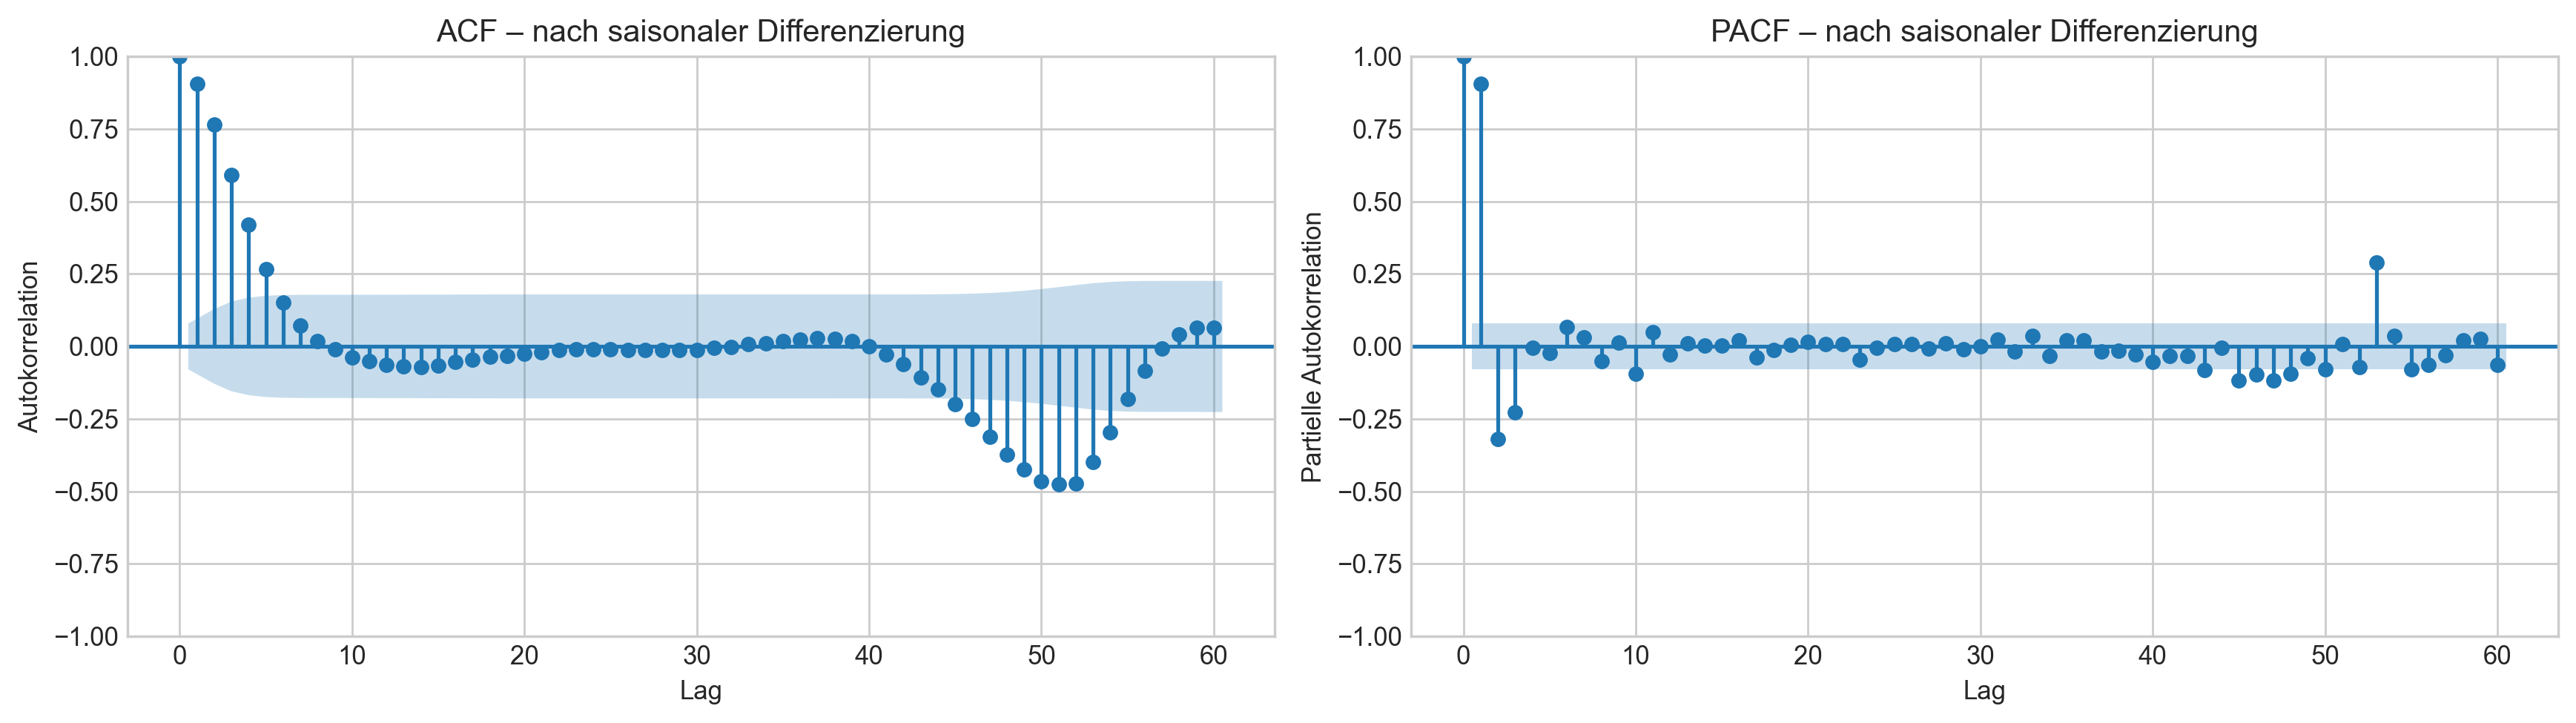

In [22]:
# ACF und PACF der saisonal differenzierten Serie
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(y_diff_season, lags=60, ax=axes[0], title='ACF – nach saisonaler Differenzierung')
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autokorrelation")

plot_pacf(y_diff_season, lags=60, ax=axes[1], title='PACF – nach saisonaler Differenzierung', method='ywm')
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Partielle Autokorrelation")

plt.tight_layout()
plt.show()


### Interpretation ACF/PACF (saisonal differenziert)

Nach der saisonalen Differenzierung ($D=1, s=52$) sehen die Plots deutlich anders aus:

**ACF (Autokorrelationsfunktion):**
*   **Exponentieller Abfall:** Im Gegensatz zur Originalserie fällt die ACF jetzt relativ zügig ab, bleibt aber für die ersten 5 Lags signifikant positiv. Das deutet auf einen verbleibenden Autoregressiven (AR) Anteil hin. Der Wert von heute hängt noch mit dem Wert von Gestern, Vorgestern etc. zusammen.

*   **Saisonalität entfernt:** Die extremen Peaks bei Lag 52 sind verschwunden bzw. stark reduziert. Es gibt zwar noch Wellenbewegungen (negativer Bereich bei Lag 50), aber das dominante saisonale Muster wurde erfolgreich bereinigt.

**PACF (Partielle Autokorrelation):**
*   **Dominanter Peak bei Lag 1:** Der erste Lag ist extrem signifikant (positiv).

*   **Cut-off nach Lag 1:** Nach dem ersten Lag bricht die PACF fast sofort ab (Lag 2 ist negativ, aber deutlich kleiner).

*   **Bedeutung:** Ein starker erster Lag in der PACF bei gleichzeitigem exponentiellen Abfall in der ACF ist das klassische Kennzeichen für einen AR(1)-Prozess.

### Finale Modellwahl für SARIMA

Basierend auf der Analyse der ACF/PACF-Plots entscheide ich mich für folgendes Modell:

**SARIMA(1, 0, 1)(1, 1, 1)[52]**

Begründung der Parameter:
*   **AR(p=1):** Der klare Cut-off in der PACF bei Lag 1 ist ein starkes Indiz für einen autoregressiven Prozess erster Ordnung (die Vorwoche erklärt die aktuelle Woche).
*   **I(d=0):** Da wir die Daten bereits vorab saisonal differenziert haben und der ADF-Test Stationarität anzeigte, ist keine weitere Trend-Differenzierung nötig. (Im Gesamtmodell entspricht das D=1, d=0).
*   **MA(q=1):** Die ACF fällt nicht schlagartig auf 0, sondern läuft aus. Ein Moving-Average-Term (q=1) hilft, verbleibende kurzfristige Schocks im Fehlerterm zu glätten.
*   **Saisonal (P=1, D=1, Q=1, s=52):** Die saisonale Differenzierung (D=1) ist gesetzt. P=1 und Q=1 erlauben dem Modell, die verbleibenden leichten saisonalen Muster in den Residuen flexibel aufzufangen.

Auswahl Sarima mit ACF & PACF begründen 

## **9. Train-Test-Split für Modellvalidierung**

In [23]:
forecast_horizon = 4

train = y
test_full = pd.read_csv("data/influenza_cases_ch_newest.csv", parse_dates=["date"], index_col="date")["incValue"]

# Testdaten sind alle Werte, die im "newest"-File enthalten sind, aber noch nicht im ursprünglichen Trainings-File
test = test_full.loc[~test_full.index.isin(train.index)]

print(f"Trainingsdaten: {len(train)} Beobachtungen ({train.index.min().date()} bis {train.index.max().date()})")
print(f"Testdaten:      {len(test)} Beobachtungen ({test.index.min().date()} bis {test.index.max().date()})")
print(f"\nTestwerte (die wir vorhersagen wollen):")
print(test)


Trainingsdaten: 665 Beobachtungen (2013-01-02 bis 2025-10-15)
Testdaten:      7 Beobachtungen (2013-07-03 bis 2025-11-12)

Testwerte (die wir vorhersagen wollen):
date
2013-07-03     2.49
2018-07-04     0.00
2024-07-03    12.74
2025-10-22    26.56
2025-10-29    35.00
2025-11-05    32.36
2025-11-12    61.31
Name: incValue, dtype: float64


## **10. Baseline-Modelle**


In [24]:
# Baseline 1: Naive Prognose (letzter bekannter Wert)
baseline_naive = pd.Series([train.iloc[-1]] * forecast_horizon, index=test.index)

# Baseline 2: Saisonale Naive (Wert der gleichen Woche im Vorjahr)
baseline_seasonal = y.shift(52)[-forecast_horizon:]

print("Baseline-Prognosen:")
print("\n1. Naive (letzter Wert):")
print(baseline_naive)
print("\n2. Saisonale Naive (Vorjahreswoche):")
print(baseline_seasonal)


ValueError: Length of values (4) does not match length of index (7)

## **11. SARIMA-Modell**

In [ ]:
# SARIMA-Modell basierend auf ACF/PACF-Analyse

# Konfiguration: SARIMA(p,d,q)(P,D,Q,s)
# - p=1 (AR1), d=0 (keine Trend-Diff), q=1 (MA1)
# - P=1, D=1 (Saison-Diff), Q=1, s=52 (Jahreszyklus)

# Modell fitten
model = SARIMAX(train, 
                order=(1, 0, 1), 
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

print("Modell-Zusammenfassung:")
print(model_fit.summary().tables[1])

Modell-Zusammenfassung:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8568      0.015     57.410      0.000       0.828       0.886
ma.L1          0.3205      0.028     11.347      0.000       0.265       0.376
ar.S.L52       0.0214      0.006      3.646      0.000       0.010       0.033
ma.S.L52      -0.7114      0.025    -28.379      0.000      -0.761      -0.662
sigma2       394.3339     11.351     34.739      0.000     372.085     416.582


Vergleich zu naiven Model, was sagen sie aus? Interpretation

In [ ]:
# 4-Wochen-Prognose
forecast = model_fit.forecast(steps=forecast_horizon)
forecast.index = test.index

print("SARIMA 4-Wochen-Prognose:")
print(forecast)


SARIMA 4-Wochen-Prognose:
date
2025-10-22    38.699065
2025-10-29    36.799794
2025-11-05    43.782245
2025-11-12    47.654766
Name: predicted_mean, dtype: float64


## **12. Vergleich und Evaluation**

In [ ]:
# Fehlermetriken berechnen
def evaluate_forecast(actual, predicted, name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return {'Modell': name, 'MAE': mae, 'RMSE': rmse}

results = []
results.append(evaluate_forecast(test, baseline_naive, 'Naive (letzter Wert)'))
results.append(evaluate_forecast(test, baseline_seasonal, 'Saisonal (Vorjahr)'))
results.append(evaluate_forecast(test, forecast, 'SARIMA(1,0,1)(1,1,1)[52]'))

results_df = pd.DataFrame(results)
print("MODELLVERGLEICH – Prognosegüte")
print(results_df.to_string(index=False))
print("\nBestes Modell nach MAE:", results_df.loc[results_df['MAE'].idxmin(), 'Modell'])
print("Bestes Modell nach RMSE:", results_df.loc[results_df['RMSE'].idxmin(), 'Modell'])


MODELLVERGLEICH – Prognosegüte
                  Modell       MAE      RMSE
    Naive (letzter Wert) 10.857500 16.362803
      Saisonal (Vorjahr)  8.935000 12.642251
SARIMA(1,0,1)(1,1,1)[52]  9.754085 10.811213

Bestes Modell nach MAE: Saisonal (Vorjahr)
Bestes Modell nach RMSE: SARIMA(1,0,1)(1,1,1)[52]


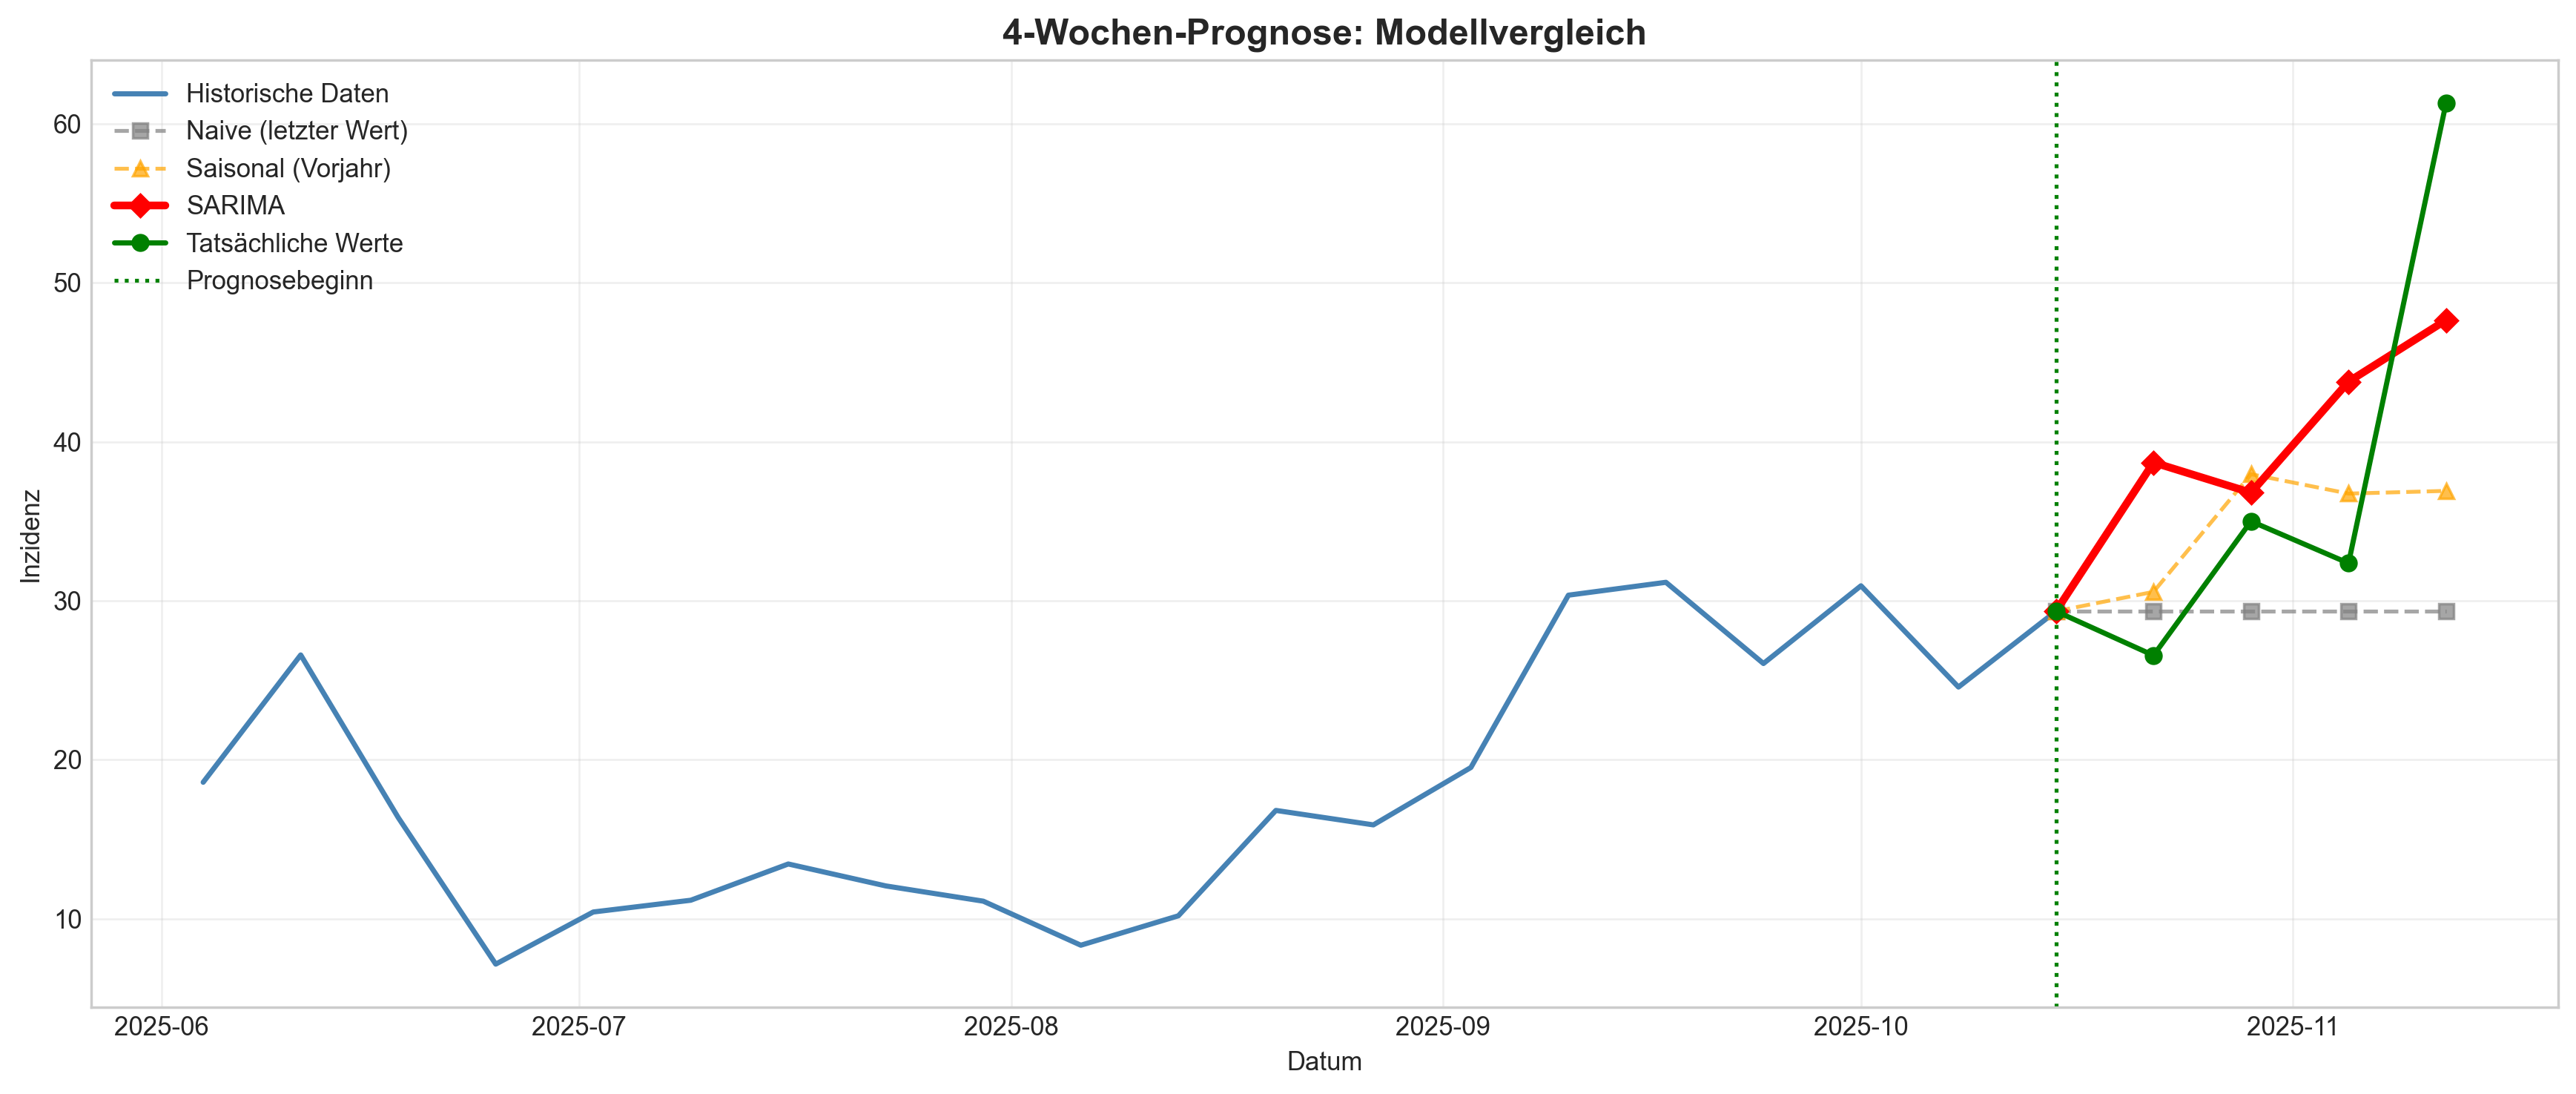

In [ ]:
# Visualisierung der Prognosen
plt.figure(figsize=(14, 6))

# Letzte 20 Wochen der Trainingsdaten
last_train_date = train.index[-1]
last_train_val = train.iloc[-1]

plt.plot(train[-20:], label='Historische Daten', color='steelblue', linewidth=2)

plot_dates = [last_train_date] + list(test.index)

# Naive Linie (startet bei letztem Train-Wert)
plot_naive = [last_train_val] + list(baseline_naive.values)
plt.plot(plot_dates, plot_naive, label='Naive (letzter Wert)', color='gray', linestyle='--', marker='s', alpha=0.7)

# Saisonale Linie (startet bei letztem Train-Wert, dann Prognose)
plot_seasonal = [last_train_val] + list(baseline_seasonal.values)
plt.plot(plot_dates, plot_seasonal, label='Saisonal (Vorjahr)', color='orange', linestyle='--', marker='^', alpha=0.7)

# SARIMA Linie
plot_sarima = [last_train_val] + list(forecast.values)
plt.plot(plot_dates, plot_sarima, label='SARIMA', color='red', linewidth=3, marker='D')

# Tatsächliche Werte (Test)
plot_actual = [last_train_val] + list(test.values)
plt.plot(plot_dates, plot_actual, label='Tatsächliche Werte', color='green', linewidth=2, marker='o')

plt.axvline(x=last_train_date, color='green', linestyle=':', label='Prognosebeginn')
plt.title('4-Wochen-Prognose: Modellvergleich', fontsize=14, fontweight='bold')
plt.xlabel('Datum')
plt.ylabel('Inzidenz')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Detaillierter Vergleich
comparison_df = pd.DataFrame({
    'Datum': test.index.date,
    'Tatsächlich': test.values,
    'Naive': baseline_naive.values,
    'Saisonal': baseline_seasonal.values,
    'SARIMA': forecast.values
})

print("\nDetaillierter Vergleich der Prognosen:")
print(comparison_df.to_string(index=False))



Detaillierter Vergleich der Prognosen:
     Datum  Tatsächlich  Naive  Saisonal    SARIMA
2025-10-22        26.56  29.34     30.56 38.699065
2025-10-29        35.00  29.34     37.96 36.799794
2025-11-05        32.36  29.34     36.74 43.782245
2025-11-12        61.31  29.34     36.91 47.654766


## **13. Fazit der Modellierung**

Der Vergleich der Prognosemodelle für den 4-Wochen-Horizont (Okt/Nov 2025) liefert interessante Erkenntnisse:

**1. Performance der Modelle:**
*   **Saisonale Baseline:** Liefert den besten MAE (8.94). Das bestätigt die extrem hohe Saisonalität der Influenza. Einfach zu sagen "es passiert das Gleiche wie letztes Jahr" ist im Durchschnitt schon ziemlich präzise.
*   **SARIMA(1,0,1)(1,1,1)[52]:** Liefert den besten RMSE (10.81). Da der RMSE grosse Abweichungen stärker bestraft als der MAE, schneidet das SARIMA-Modell besser ab, da es die starke Zunahme am Schluss besser abbildet als die starre saisonale Baseline.
*   **Naive Prognose:** Schneidet deutlich am schlechtesten ab. Das zeigt, dass man bei saisonalen Daten niemals einfach den letzten Wert fortschreiben darf.

**2. Interpretation der Prognosewerte:**
*   Die tatsächlichen Werte steigen am Ende stark an (auf 61.31).
*   Das **SARIMA-Modell** hat diesen Anstieg erkannt und prognostiziert ebenfalls einen Trend nach oben (von 38 auf 47), auch wenn es den steilen Sprung in der letzten Woche etwas unterschätzt.
*   Die **Saisonale Baseline** bleibt relativ flach bei ~37 stehen und verpasst den starken Anstieg in der letzten Woche komplett.

**Gesamtfazit:**
Für die Minimierung des absoluten Fehlers ist die einfache saisonale Baseline schwer zu schlagen. Wenn es jedoch darum geht, Trendwenden (wie den Beginn der Winterwelle) dynamisch zu erkennen und grosse Fehlprognosen zu vermeiden, ist das SARIMA-Modell überlegen. Es kombiniert das Wissen aus dem Vorjahr (Saison) mit der aktuellen Dynamik (AR/MA).